# 0. 환경설정 및 데이터 업로드

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV

from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb 

import graphviz
from sklearn.tree import export_graphviz
from plotnine import *
import plotnine

from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
# 학습용 데이터
model_data = pd.read_csv('./data/KOTRA_학습용_데이터.csv') 
model_data.drop(['UNC_YEAR','COUNTRYCD','NY_GDP_MKTP_CD_1Y'], axis = 1, inplace = True)

# 예측용 데이터
predict_data = pd.read_csv('./data/KOTRA_예측용_데이터.csv')
predict_data.drop(['UNC_YEAR','COUNTRYCD','NY_GDP_MKTP_CD_1Y'], axis = 1, inplace = True)

# 원본 데이터 로드
raw_data = pd.read_csv('./data/공모전데이터_분석용_KOTRA_0525.csv')
raw_data.drop(['UNC_YEAR','COUNTRYCD','NY_GDP_MKTP_CD_1Y'], axis = 1, inplace = True)
submission = pd.read_csv('./data/공모전데이터_예측용_KOTRA_0525.csv')
submission.drop(['UNC_YEAR','COUNTRYCD','NY_GDP_MKTP_CD_1Y'], axis = 1, inplace = True)

# 1. 분석용 데이터 전처리

### 1.1) 로그(Log) 변환

In [3]:
def Log_scale(raw_data, model_data):
    raw_df = raw_data.copy()
    model_df = model_data.copy()
    
    skewness = raw_df.drop(['COUNTRYNM','HSCD'], axis = 1).apply(lambda x: x.skew()).sort_values(ascending=False)
    skew_feats = skewness[skewness>1].index
    print('로그(Log)변환을 적용할 변수명 : ', skew_feats.to_list())
    
    model_df[skew_feats] = np.log1p(model_df[skew_feats])
    
    return model_df

model_data = Log_scale(raw_data, model_data)
predict_data = Log_scale(submission, predict_data)

model_data.shape, predict_data.shape

로그(Log)변환을 적용할 변수명 :  ['KR_TRADE_HSCD_COUNTRYCD', 'TRADE_HSCD_COUNTRYCD', 'TARIFF_AVG', 'TRADE_HSCD', 'NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'TRADE_COUNTRYCD']
로그(Log)변환을 적용할 변수명 :  ['TRADE_HSCD_COUNTRYCD', 'TARIFF_AVG', 'TRADE_HSCD', 'NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'TRADE_COUNTRYCD']


((21189, 49), (21189, 49))

### 1.2) 정규화(MinMaxScaler) 스케일링

In [4]:
def MINMAX_SC(raw_data, model_data):
    raw_df = raw_data.copy()
    df = model_data.copy()
    
    # 카테고리형 제외한 Minmax 정규화
    skewness = raw_df.drop(['COUNTRYNM','HSCD'], axis = 1).apply(lambda x: x.skew()).sort_values(ascending=False)
    skew_feats = skewness[skewness>1].index
    
    numerical_feats = df.dtypes[df.dtypes != "object"].index.tolist()
    numerical_feats.remove('HSCD')
    numerical_feats.remove('KR_TRADE_HSCD_COUNTRYCD')
    
    numerical_feats = list(set(numerical_feats) - set(skew_feats))
    df[numerical_feats] = MinMaxScaler().fit_transform(df[numerical_feats])
    
    return df
    
model_data = MINMAX_SC(raw_data, model_data) # model_data
predict_data = MINMAX_SC(submission, predict_data)
model_data.shape, predict_data.shape

((21189, 49), (21189, 49))

### 1.3) 레이블 인코딩(LabelEncoding)

In [5]:
def Label_enc(data):
    df = data.copy()
    
    # HSCD, COUNTRYNM, Category_L, Category_M, Category_S 5개 변수에 대해 적용
    df['HSCD'] = LabelEncoder().fit_transform(df['HSCD'].values)
    df['COUNTRYNM'] = LabelEncoder().fit_transform(df['COUNTRYNM'].values)
    df['Category_L'] = LabelEncoder().fit_transform(df['Category_L'].values)
    df['Category_M'] = LabelEncoder().fit_transform(df['Category_M'].values)
    df['Category_S'] = LabelEncoder().fit_transform(df['Category_S'].values)
    
    return df

model_data_label = Label_enc(model_data)
predict_data_label = Label_enc(predict_data)

model_data_label.shape, predict_data_label.shape

((21189, 49), (21189, 49))

### 1.4) 원핫 인코딩(One-hotEncoding)

In [6]:
def Onehot_enc(data):
    df = data.copy()
    
    # HSCD, COUNTRYNM, Category_L, Category_M, Category_S 5개 변수에 대해 적용
    object_col = ['HSCD', 'COUNTRYNM', 'Category_L', 'Category_M', 'Category_S']

    enc = OneHotEncoder()
    enc.fit(df.loc[:,object_col])
    onehot_df = pd.DataFrame(enc.transform(df.loc[:,object_col]).toarray(), columns = enc.get_feature_names(object_col))
    
    df.drop(object_col, axis=1, inplace=True)
    df = pd.concat([df, onehot_df], axis=1)   
    
    return df

model_data_onehot = Onehot_enc(model_data)
predict_data_onehot = Onehot_enc(predict_data)

model_data_onehot.shape, predict_data_onehot.shape

((21189, 647), (21189, 647))

### 1.5) 이상치(Outlier) 확인

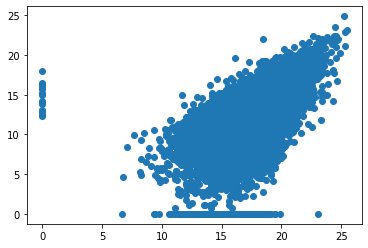

In [7]:
plt.scatter(x = model_data_label['TRADE_HSCD_COUNTRYCD'], y = model_data_label['KR_TRADE_HSCD_COUNTRYCD'])
plt.show()

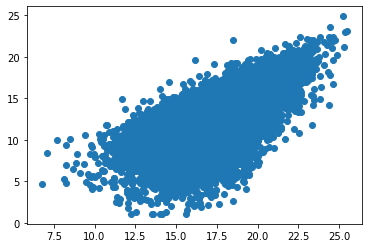

In [8]:
def Outlier_remove(label_data, onehot_data):
    df1 = label_data.copy()
    df2 = onehot_data.copy()
    
    df1 = df1[df1['KR_TRADE_HSCD_COUNTRYCD'] > 1]
    df1 = df1[df1['TRADE_HSCD_COUNTRYCD'] > 1]
    df1.reset_index(drop=True, inplace=True)

    df2 = df2[df2['KR_TRADE_HSCD_COUNTRYCD'] > 1]
    df2 = df2[df2['TRADE_HSCD_COUNTRYCD'] > 1]
    df2.reset_index(drop=True, inplace=True)
    
    return df1, df2

model_data_label, model_data_onehot = Outlier_remove(model_data_label, model_data_onehot)

plt.scatter(x = model_data_label['TRADE_HSCD_COUNTRYCD'], y = model_data_label['KR_TRADE_HSCD_COUNTRYCD'])
plt.show()

### 1.6) 상관계수(Correlation) 확인

In [9]:
# 상관계수 데이터 불러오기
cor_data = model_data_label.copy()
cor_data.drop(['HSCD', 'COUNTRYNM'], axis = 1, inplace = True)

# 절대값 기준으로 상관계수 검정
corr_matrix = cor_data.corr().abs()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# 0.8 강한 상관계수 값을 보이는 변수들만 추출
corr_rel_check = (corr_matrix > 0.8).sum()-1 
corr_remove = pd.DataFrame(corr_rel_check[corr_rel_check > 0]).T

# 상관계수 다시 생성
corr_remove = cor_data[corr_remove.columns.to_list()].corr().abs()
mask = np.zeros_like(corr_remove, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

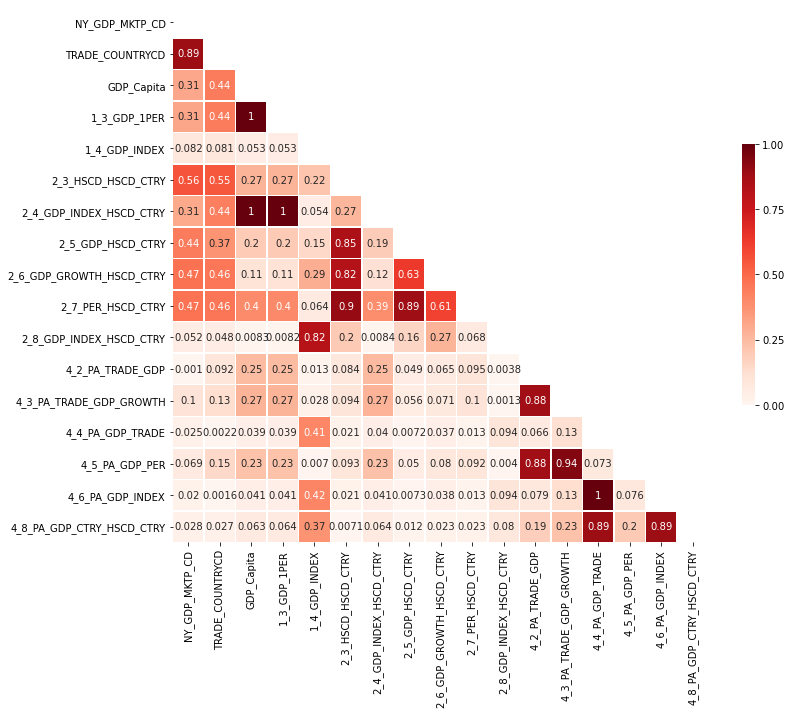

In [10]:
f, ax = plt.subplots(figsize=(12, 12))
heatmap = sns.heatmap(corr_remove,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'Reds', #
                      cbar_kws = {'shrink': .4,
                                'ticks' : [0 , 0.25, 0.5, 0.75 , 1]},
                      vmin = 0,
                      vmax = 1,
                      annot = True
                     )
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [11]:
corr_remove.columns

Index(['NY_GDP_MKTP_CD', 'TRADE_COUNTRYCD', 'GDP_Capita', '1_3_GDP_1PER',
       '1_4_GDP_INDEX', '2_3_HSCD_HSCD_CTRY', '2_4_GDP_INDEX_HSCD_CTRY',
       '2_5_GDP_HSCD_CTRY', '2_6_GDP_GROWTH_HSCD_CTRY', '2_7_PER_HSCD_CTRY',
       '2_8_GDP_INDEX_HSCD_CTRY', '4_2_PA_TRADE_GDP',
       '4_3_PA_TRADE_GDP_GROWTH', '4_4_PA_GDP_TRADE', '4_5_PA_GDP_PER',
       '4_6_PA_GDP_INDEX', '4_8_PA_GDP_CTRY_HSCD_CTRY'],
      dtype='object')

In [12]:
def corr_remove(data):
    df = data.copy()
    
    df.drop(['NY_GDP_MKTP_CD', 'GDP_Capita', 
             '2_3_HSCD_HSCD_CTRY', '2_4_GDP_INDEX_HSCD_CTRY', '2_7_PER_HSCD_CTRY', '2_8_GDP_INDEX_HSCD_CTRY',
             '4_3_PA_TRADE_GDP_GROWTH', '4_4_PA_GDP_TRADE', '4_5_PA_GDP_PER', '4_8_PA_GDP_CTRY_HSCD_CTRY'], 
              axis =1 , inplace = True)
    
    return df    

model_data_label = corr_remove(model_data_label)
model_data_onehot = corr_remove(model_data_onehot)

predict_data_label = corr_remove(predict_data_label)
predict_data_onehot = corr_remove(predict_data_onehot)

#### 최종 데이터 셋 구성 

In [13]:
model_data_label.shape, model_data_onehot.shape, predict_data_label.shape, predict_data_onehot.shape

((20827, 39), (20827, 637), (21189, 39), (21189, 637))

# 2. 모델링(Modeling)

#### 회귀 평가 함수 생성

In [14]:
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### 2.1) 회귀기반 모델 제안

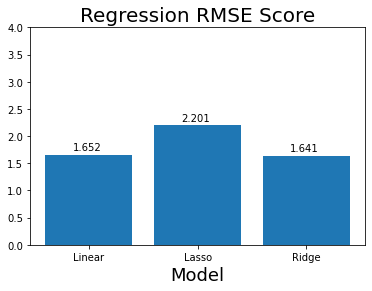

In [15]:
# X데이터와 Y데이터 분할
X_data_oh = model_data_onehot.drop(['KR_TRADE_HSCD_COUNTRYCD'], axis=1,inplace=False)
y_data_oh = model_data_onehot['KR_TRADE_HSCD_COUNTRYCD']

# 학습비율 8:2로 train과 test셋 분할
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(X_data_oh, y_data_oh, test_size=0.20, random_state = 42)

# 선형 모델 3가지와 Tree & Boosting 기반 모델 3가지를 dict으로 저장
models = {
    'Linear' :LinearRegression().fit(X_train_oh, y_train_oh),
    'Lasso': Lasso().fit(X_train_oh, y_train_oh),
    'Ridge': Ridge().fit(X_train_oh, y_train_oh)
}

# 테스트 데이터셋(20%)를 예측
Linear_model = models['Linear'].predict(X_test_oh)
Lasso_model = models['Lasso'].predict(X_test_oh)
Ridge_model = models['Ridge'].predict(X_test_oh)

# 테스트 데이터 셋의 RMSE 계산
rmse_score = [RMSE(Linear_model, y_test_oh),
               RMSE(Lasso_model, y_test_oh),
               RMSE(Ridge_model, y_test_oh)]

x_lab = ['Linear', 'Lasso', 'Ridge']

plt.bar(x_lab, rmse_score)
plt.title('Regression RMSE Score', fontsize=20)
plt.xlabel('Model', fontsize=18)
plt.ylabel('', fontsize=18)
plt.ylim(0,4)

# 막대그래프 위에 값을 표시
for i, v in enumerate(rmse_score):
    plt.text(i-0.15, v + 0.08, str(np.round(v,3))) 
    
plt.show()

### 2.2) 트리 기반 부스팅 모델 제안

Learning rate set to 0.370564
0:	learn: 2.4664905	total: 161ms	remaining: 15.9s
1:	learn: 2.2339561	total: 175ms	remaining: 8.57s
2:	learn: 2.1178196	total: 185ms	remaining: 5.99s
3:	learn: 2.0447477	total: 196ms	remaining: 4.7s
4:	learn: 2.0022065	total: 206ms	remaining: 3.92s
5:	learn: 1.9587486	total: 216ms	remaining: 3.38s
6:	learn: 1.9363123	total: 225ms	remaining: 2.99s
7:	learn: 1.9193176	total: 235ms	remaining: 2.7s
8:	learn: 1.9005672	total: 244ms	remaining: 2.46s
9:	learn: 1.8871163	total: 253ms	remaining: 2.27s
10:	learn: 1.8791955	total: 261ms	remaining: 2.12s
11:	learn: 1.8688235	total: 270ms	remaining: 1.98s
12:	learn: 1.8585225	total: 279ms	remaining: 1.87s
13:	learn: 1.8540681	total: 286ms	remaining: 1.76s
14:	learn: 1.8480851	total: 294ms	remaining: 1.67s
15:	learn: 1.8410280	total: 302ms	remaining: 1.59s
16:	learn: 1.8339809	total: 311ms	remaining: 1.52s
17:	learn: 1.8257625	total: 318ms	remaining: 1.45s
18:	learn: 1.8231934	total: 326ms	remaining: 1.39s
19:	learn: 1.

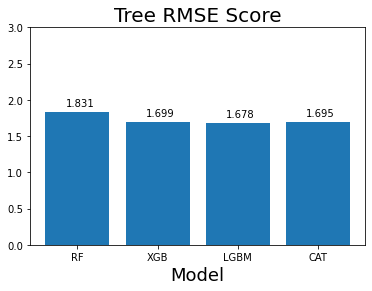

In [16]:
# X데이터와 Y데이터 분할
X_data_lab = model_data_label.drop(['KR_TRADE_HSCD_COUNTRYCD'], axis=1,inplace=False)
y_data_lab = model_data_label['KR_TRADE_HSCD_COUNTRYCD']

# 학습비율 8:2로 train과 test셋 분할
X_train_lab, X_test_lab, y_train_lab, y_test_lab = train_test_split(X_data_lab, y_data_lab, test_size=0.20, random_state = 42)

# 선형 모델 3가지와 Tree & Boosting 기반 모델 3가지를 dict으로 저장
models = {
    'RF' : RandomForestRegressor(n_estimators = 100, random_state=42, n_jobs=-1).fit(X_train_lab, y_train_lab),
    'XGB' : xgb.XGBRegressor(n_estimators = 100, random_state=42, n_jobs=-1).fit(X_train_lab, y_train_lab),
    'LGBM' : LGBMRegressor(n_estimators = 100, random_state=42, n_jobs=-1).fit(X_train_lab, y_train_lab),
    'CAT' : CatBoostRegressor(n_estimators = 100, random_state=42).fit(X_train_lab, y_train_lab)
}

# 테스트 데이터셋(20%)를 예측
RF_model = models['RF'].predict(X_test_lab)
XGB_model = models['XGB'].predict(X_test_lab)
LGBM_model = models['LGBM'].predict(X_test_lab)
CAT_model = models['CAT'].predict(X_test_lab)

# 테스트 데이터 셋의 RMSE 계산
rmse_score = [ RMSE(RF_model, y_test_lab),
               RMSE(XGB_model, y_test_lab),
               RMSE(LGBM_model, y_test_lab),
               RMSE(CAT_model, y_test_lab)]

x_lab = ['RF', 'XGB', 'LGBM','CAT']

plt.bar(x_lab, rmse_score) # 단위 :: 백만원
plt.title('Tree RMSE Score', fontsize=20)
plt.xlabel('Model', fontsize=18)
plt.ylabel('', fontsize=18)
plt.ylim(0,3)

# 막대그래프 위에 값을 표시
for i, v in enumerate(rmse_score):
    plt.text(i-0.15, v + 0.08, str(np.round(v,3))) 
    
plt.show()

### 2.3) 릿지 회귀(Ridge regression model)

#### 하이퍼 파라미터 최적화(Grid SearchCV)

In [17]:
ridge_params = {'alpha':np.logspace(-4, 1, 20)} 
print(GridSearchCV(Ridge(), param_grid=ridge_params, cv = 5).fit(X_data_oh, y_data_oh).best_estimator_)

Ridge(alpha=10.0)


#### 모델 학습 및 예측

In [18]:
seed = 84
n_fold = 10
Ridge_models={}

kf = KFold(n_splits=10, shuffle=True, random_state=84)

folds=[]
for train_idx, valid_idx in kf.split(X_train_oh):
    folds.append((train_idx, valid_idx))


for fold in range(10):
    # 데이터 분할
    train_idx, valid_idx = folds[fold] 
    X_train, X_valid, y_train, y_valid = model_data_onehot.drop(['KR_TRADE_HSCD_COUNTRYCD'],axis=1).iloc[train_idx].values,\
                                         model_data_onehot.drop(['KR_TRADE_HSCD_COUNTRYCD'],axis=1).iloc[valid_idx].values,\
                                         model_data_onehot['KR_TRADE_HSCD_COUNTRYCD'][train_idx].values,\
                                         model_data_onehot['KR_TRADE_HSCD_COUNTRYCD'][valid_idx].values   

      
    # 모델
    ridge_params = {'alpha' : 10}
    
    Ridge_model = Ridge(**ridge_params).fit(X_train, y_train)
    
    score = Ridge_model.predict(X_valid)
    print(fold+1 , ': validation-rmse : ',RMSE(score, y_valid))
    Ridge_models[fold]=Ridge_model
    
# OOF(Out of Fold) 검증
Ridge_result = X_test_oh.copy()
Ridge_result['rslt'] = 0

for fold in range(10):
    Ridge_result['rslt'] += Ridge_models[fold].predict(X_test_oh) / 10
    
print('# Total RMSE : ', RMSE(Ridge_result['rslt'], y_test_oh))

1 : validation-rmse :  1.6756399007879907
2 : validation-rmse :  1.6616206194289063
3 : validation-rmse :  1.6812861005310804
4 : validation-rmse :  1.6514305725091944
5 : validation-rmse :  1.7150149252880282
6 : validation-rmse :  1.6655123396310663
7 : validation-rmse :  1.755744640480833
8 : validation-rmse :  1.5807211473745517
9 : validation-rmse :  1.7436809730413194
10 : validation-rmse :  1.6495736509208987
# Total RMSE :  1.6685129229758808


### 2.4) LGBM(Light gradient boosting model)

#### 하이퍼 파라미터 최적화(Random SearchCV)

In [19]:
X_train_lab, X_test_lab, y_train_lab, y_test_lab = train_test_split(X_data_lab, y_data_lab, test_size=0.20, random_state = 42)

lgbm_params = {
    'max_depth': [9, 12, 15],
    'num_leaves': [70, 90, 110, 120, 150],
    'min_child_samples': [15, 20, 25],
    'colsample_bytree': [0.5, 0.7, 0.9], 
    'subsample': [0.5, 0.7, 0.9],
}

grid = RandomizedSearchCV(LGBMRegressor(learning_rate = 0.05, n_estimators = 1000, random_state=84), lgbm_params, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train_lab, y_train_lab, early_stopping_rounds=50, eval_set=[(X_train_lab, y_train_lab), (X_test_lab, y_test_lab)])

[1]	valid_0's l2: 8.0193	valid_1's l2: 8.01167
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 7.61815	valid_1's l2: 7.60922
[3]	valid_0's l2: 7.24206	valid_1's l2: 7.23719
[4]	valid_0's l2: 6.89413	valid_1's l2: 6.89365
[5]	valid_0's l2: 6.57914	valid_1's l2: 6.58407
[6]	valid_0's l2: 6.29104	valid_1's l2: 6.29964
[7]	valid_0's l2: 6.02946	valid_1's l2: 6.04043
[8]	valid_0's l2: 5.79111	valid_1's l2: 5.8029
[9]	valid_0's l2: 5.5735	valid_1's l2: 5.59044
[10]	valid_0's l2: 5.37747	valid_1's l2: 5.39941
[11]	valid_0's l2: 5.19739	valid_1's l2: 5.22431
[12]	valid_0's l2: 5.03105	valid_1's l2: 5.06391
[13]	valid_0's l2: 4.87957	valid_1's l2: 4.91654
[14]	valid_0's l2: 4.74335	valid_1's l2: 4.78373
[15]	valid_0's l2: 4.61422	valid_1's l2: 4.65942
[16]	valid_0's l2: 4.4981	valid_1's l2: 4.55018
[17]	valid_0's l2: 4.39054	valid_1's l2: 4.44989
[18]	valid_0's l2: 4.28985	valid_1's l2: 4.35542
[19]	valid_0's l2: 4.19573	valid_1's l2: 4.2661
[20]	valid_0's l2: 4.1

[183]	valid_0's l2: 2.08108	valid_1's l2: 2.81854
[184]	valid_0's l2: 2.07833	valid_1's l2: 2.81725
[185]	valid_0's l2: 2.07452	valid_1's l2: 2.81591
[186]	valid_0's l2: 2.07371	valid_1's l2: 2.81638
[187]	valid_0's l2: 2.07289	valid_1's l2: 2.81558
[188]	valid_0's l2: 2.06996	valid_1's l2: 2.81655
[189]	valid_0's l2: 2.06753	valid_1's l2: 2.81628
[190]	valid_0's l2: 2.06306	valid_1's l2: 2.81501
[191]	valid_0's l2: 2.05806	valid_1's l2: 2.81386
[192]	valid_0's l2: 2.05579	valid_1's l2: 2.81378
[193]	valid_0's l2: 2.05341	valid_1's l2: 2.81351
[194]	valid_0's l2: 2.05082	valid_1's l2: 2.81264
[195]	valid_0's l2: 2.04765	valid_1's l2: 2.81126
[196]	valid_0's l2: 2.04485	valid_1's l2: 2.81124
[197]	valid_0's l2: 2.04348	valid_1's l2: 2.81016
[198]	valid_0's l2: 2.04123	valid_1's l2: 2.81019
[199]	valid_0's l2: 2.03978	valid_1's l2: 2.81006
[200]	valid_0's l2: 2.03714	valid_1's l2: 2.80932
[201]	valid_0's l2: 2.033	valid_1's l2: 2.8071
[202]	valid_0's l2: 2.03084	valid_1's l2: 2.80676
[20

[364]	valid_0's l2: 1.71503	valid_1's l2: 2.7815
[365]	valid_0's l2: 1.71357	valid_1's l2: 2.78121
[366]	valid_0's l2: 1.71183	valid_1's l2: 2.78191
[367]	valid_0's l2: 1.71068	valid_1's l2: 2.78159
[368]	valid_0's l2: 1.70937	valid_1's l2: 2.78149
[369]	valid_0's l2: 1.70855	valid_1's l2: 2.78161
[370]	valid_0's l2: 1.70757	valid_1's l2: 2.78166
[371]	valid_0's l2: 1.70571	valid_1's l2: 2.78299
[372]	valid_0's l2: 1.70468	valid_1's l2: 2.7834
[373]	valid_0's l2: 1.7025	valid_1's l2: 2.78289
[374]	valid_0's l2: 1.69945	valid_1's l2: 2.78033
[375]	valid_0's l2: 1.69839	valid_1's l2: 2.78005
[376]	valid_0's l2: 1.69623	valid_1's l2: 2.78054
[377]	valid_0's l2: 1.69353	valid_1's l2: 2.77961
[378]	valid_0's l2: 1.69278	valid_1's l2: 2.77938
[379]	valid_0's l2: 1.69202	valid_1's l2: 2.78048
[380]	valid_0's l2: 1.6903	valid_1's l2: 2.78028
[381]	valid_0's l2: 1.68856	valid_1's l2: 2.7807
[382]	valid_0's l2: 1.68738	valid_1's l2: 2.7813
[383]	valid_0's l2: 1.68558	valid_1's l2: 2.781
[384]	va

[106]	valid_0's l2: 2.38318	valid_1's l2: 2.912
[107]	valid_0's l2: 2.37806	valid_1's l2: 2.91294
[108]	valid_0's l2: 2.37128	valid_1's l2: 2.90952
[109]	valid_0's l2: 2.36663	valid_1's l2: 2.90768
[110]	valid_0's l2: 2.35908	valid_1's l2: 2.90592
[111]	valid_0's l2: 2.3547	valid_1's l2: 2.90605
[112]	valid_0's l2: 2.34798	valid_1's l2: 2.90455
[113]	valid_0's l2: 2.34054	valid_1's l2: 2.90043
[114]	valid_0's l2: 2.33521	valid_1's l2: 2.89971
[115]	valid_0's l2: 2.32836	valid_1's l2: 2.89601
[116]	valid_0's l2: 2.32449	valid_1's l2: 2.89663
[117]	valid_0's l2: 2.31793	valid_1's l2: 2.89321
[118]	valid_0's l2: 2.31091	valid_1's l2: 2.88771
[119]	valid_0's l2: 2.30391	valid_1's l2: 2.88418
[120]	valid_0's l2: 2.30007	valid_1's l2: 2.88305
[121]	valid_0's l2: 2.2956	valid_1's l2: 2.87977
[122]	valid_0's l2: 2.28809	valid_1's l2: 2.87454
[123]	valid_0's l2: 2.28197	valid_1's l2: 2.87223
[124]	valid_0's l2: 2.27857	valid_1's l2: 2.87043
[125]	valid_0's l2: 2.27235	valid_1's l2: 2.86747
[126

[285]	valid_0's l2: 1.8208	valid_1's l2: 2.7734
[286]	valid_0's l2: 1.81987	valid_1's l2: 2.77371
[287]	valid_0's l2: 1.81782	valid_1's l2: 2.77332
[288]	valid_0's l2: 1.81729	valid_1's l2: 2.77303
[289]	valid_0's l2: 1.8153	valid_1's l2: 2.773
[290]	valid_0's l2: 1.81314	valid_1's l2: 2.77228
[291]	valid_0's l2: 1.81186	valid_1's l2: 2.7719
[292]	valid_0's l2: 1.80903	valid_1's l2: 2.77147
[293]	valid_0's l2: 1.80714	valid_1's l2: 2.77072
[294]	valid_0's l2: 1.80553	valid_1's l2: 2.77136
[295]	valid_0's l2: 1.80468	valid_1's l2: 2.77103
[296]	valid_0's l2: 1.80244	valid_1's l2: 2.77083
[297]	valid_0's l2: 1.8004	valid_1's l2: 2.77034
[298]	valid_0's l2: 1.79949	valid_1's l2: 2.77073
[299]	valid_0's l2: 1.7975	valid_1's l2: 2.77095
[300]	valid_0's l2: 1.79533	valid_1's l2: 2.77039
[301]	valid_0's l2: 1.79343	valid_1's l2: 2.77097
[302]	valid_0's l2: 1.79073	valid_1's l2: 2.76971
[303]	valid_0's l2: 1.7883	valid_1's l2: 2.77058
[304]	valid_0's l2: 1.78459	valid_1's l2: 2.76837
[305]	val

[137]	valid_0's l2: 2.26386	valid_1's l2: 2.89818
[138]	valid_0's l2: 2.25794	valid_1's l2: 2.89566
[139]	valid_0's l2: 2.25363	valid_1's l2: 2.8947
[140]	valid_0's l2: 2.2512	valid_1's l2: 2.89466
[141]	valid_0's l2: 2.24857	valid_1's l2: 2.89345
[142]	valid_0's l2: 2.24258	valid_1's l2: 2.89061
[143]	valid_0's l2: 2.23621	valid_1's l2: 2.88769
[144]	valid_0's l2: 2.23302	valid_1's l2: 2.88718
[145]	valid_0's l2: 2.23113	valid_1's l2: 2.88746
[146]	valid_0's l2: 2.22801	valid_1's l2: 2.88729
[147]	valid_0's l2: 2.22132	valid_1's l2: 2.88369
[148]	valid_0's l2: 2.21798	valid_1's l2: 2.88362
[149]	valid_0's l2: 2.21311	valid_1's l2: 2.88257
[150]	valid_0's l2: 2.20966	valid_1's l2: 2.88356
[151]	valid_0's l2: 2.2081	valid_1's l2: 2.88392
[152]	valid_0's l2: 2.2041	valid_1's l2: 2.88289
[153]	valid_0's l2: 2.19891	valid_1's l2: 2.88023
[154]	valid_0's l2: 2.19643	valid_1's l2: 2.87889
[155]	valid_0's l2: 2.19297	valid_1's l2: 2.8799
[156]	valid_0's l2: 2.19033	valid_1's l2: 2.87959
[157]

[328]	valid_0's l2: 1.78485	valid_1's l2: 2.83355
[329]	valid_0's l2: 1.78365	valid_1's l2: 2.83404
[330]	valid_0's l2: 1.78233	valid_1's l2: 2.83451
[331]	valid_0's l2: 1.78102	valid_1's l2: 2.83479
[332]	valid_0's l2: 1.77968	valid_1's l2: 2.83478
[333]	valid_0's l2: 1.77652	valid_1's l2: 2.83325
[334]	valid_0's l2: 1.77575	valid_1's l2: 2.83333
[335]	valid_0's l2: 1.77477	valid_1's l2: 2.8332
[336]	valid_0's l2: 1.77146	valid_1's l2: 2.83147
[337]	valid_0's l2: 1.7706	valid_1's l2: 2.83168
[338]	valid_0's l2: 1.76868	valid_1's l2: 2.83156
[339]	valid_0's l2: 1.76771	valid_1's l2: 2.83175
[340]	valid_0's l2: 1.7663	valid_1's l2: 2.83177
[341]	valid_0's l2: 1.76552	valid_1's l2: 2.83211
[342]	valid_0's l2: 1.76454	valid_1's l2: 2.83232
[343]	valid_0's l2: 1.7613	valid_1's l2: 2.83185
[344]	valid_0's l2: 1.76054	valid_1's l2: 2.83208
[345]	valid_0's l2: 1.75843	valid_1's l2: 2.83343
[346]	valid_0's l2: 1.75613	valid_1's l2: 2.83386
[347]	valid_0's l2: 1.75399	valid_1's l2: 2.83329
[348

[127]	valid_0's l2: 1.99137	valid_1's l2: 2.82283
[128]	valid_0's l2: 1.98636	valid_1's l2: 2.82311
[129]	valid_0's l2: 1.9821	valid_1's l2: 2.82316
[130]	valid_0's l2: 1.97932	valid_1's l2: 2.82224
[131]	valid_0's l2: 1.97421	valid_1's l2: 2.82001
[132]	valid_0's l2: 1.97268	valid_1's l2: 2.81991
[133]	valid_0's l2: 1.96715	valid_1's l2: 2.81887
[134]	valid_0's l2: 1.96037	valid_1's l2: 2.81665
[135]	valid_0's l2: 1.95347	valid_1's l2: 2.81456
[136]	valid_0's l2: 1.94846	valid_1's l2: 2.81374
[137]	valid_0's l2: 1.94339	valid_1's l2: 2.81151
[138]	valid_0's l2: 1.93914	valid_1's l2: 2.80899
[139]	valid_0's l2: 1.93595	valid_1's l2: 2.80816
[140]	valid_0's l2: 1.93201	valid_1's l2: 2.80602
[141]	valid_0's l2: 1.92695	valid_1's l2: 2.80467
[142]	valid_0's l2: 1.92553	valid_1's l2: 2.80494
[143]	valid_0's l2: 1.92202	valid_1's l2: 2.80468
[144]	valid_0's l2: 1.91712	valid_1's l2: 2.80455
[145]	valid_0's l2: 1.9125	valid_1's l2: 2.80463
[146]	valid_0's l2: 1.90864	valid_1's l2: 2.80648
[1

[53]	valid_0's l2: 2.69898	valid_1's l2: 3.18329
[54]	valid_0's l2: 2.68472	valid_1's l2: 3.1783
[55]	valid_0's l2: 2.67182	valid_1's l2: 3.17534
[56]	valid_0's l2: 2.65161	valid_1's l2: 3.16077
[57]	valid_0's l2: 2.63572	valid_1's l2: 3.15191
[58]	valid_0's l2: 2.62327	valid_1's l2: 3.14804
[59]	valid_0's l2: 2.61155	valid_1's l2: 3.1456
[60]	valid_0's l2: 2.59841	valid_1's l2: 3.14161
[61]	valid_0's l2: 2.57291	valid_1's l2: 3.12346
[62]	valid_0's l2: 2.55978	valid_1's l2: 3.11469
[63]	valid_0's l2: 2.54662	valid_1's l2: 3.10788
[64]	valid_0's l2: 2.53804	valid_1's l2: 3.10625
[65]	valid_0's l2: 2.52623	valid_1's l2: 3.10151
[66]	valid_0's l2: 2.50449	valid_1's l2: 3.08435
[67]	valid_0's l2: 2.48943	valid_1's l2: 3.07565
[68]	valid_0's l2: 2.47913	valid_1's l2: 3.07201
[69]	valid_0's l2: 2.46721	valid_1's l2: 3.06891
[70]	valid_0's l2: 2.45025	valid_1's l2: 3.05993
[71]	valid_0's l2: 2.4332	valid_1's l2: 3.04987
[72]	valid_0's l2: 2.41975	valid_1's l2: 3.04111
[73]	valid_0's l2: 2.40

[231]	valid_0's l2: 1.64949	valid_1's l2: 2.78349
[232]	valid_0's l2: 1.64629	valid_1's l2: 2.78313
[233]	valid_0's l2: 1.64437	valid_1's l2: 2.7832
[234]	valid_0's l2: 1.64126	valid_1's l2: 2.7824
[235]	valid_0's l2: 1.63809	valid_1's l2: 2.78239
[236]	valid_0's l2: 1.63617	valid_1's l2: 2.78308
[237]	valid_0's l2: 1.63257	valid_1's l2: 2.78165
[238]	valid_0's l2: 1.62954	valid_1's l2: 2.78259
[239]	valid_0's l2: 1.62693	valid_1's l2: 2.78334
[240]	valid_0's l2: 1.62447	valid_1's l2: 2.78405
[241]	valid_0's l2: 1.62303	valid_1's l2: 2.78472
[242]	valid_0's l2: 1.61898	valid_1's l2: 2.78369
[243]	valid_0's l2: 1.61835	valid_1's l2: 2.78389
[244]	valid_0's l2: 1.61456	valid_1's l2: 2.78333
[245]	valid_0's l2: 1.61218	valid_1's l2: 2.7837
[246]	valid_0's l2: 1.61072	valid_1's l2: 2.78369
[247]	valid_0's l2: 1.60772	valid_1's l2: 2.78381
[248]	valid_0's l2: 1.60551	valid_1's l2: 2.78397
[249]	valid_0's l2: 1.60409	valid_1's l2: 2.78437
[250]	valid_0's l2: 1.60068	valid_1's l2: 2.78394
[25

[51]	valid_0's l2: 2.74462	valid_1's l2: 3.23457
[52]	valid_0's l2: 2.72654	valid_1's l2: 3.22248
[53]	valid_0's l2: 2.70721	valid_1's l2: 3.21397
[54]	valid_0's l2: 2.69213	valid_1's l2: 3.20925
[55]	valid_0's l2: 2.68075	valid_1's l2: 3.20531
[56]	valid_0's l2: 2.66336	valid_1's l2: 3.19186
[57]	valid_0's l2: 2.64885	valid_1's l2: 3.1847
[58]	valid_0's l2: 2.63618	valid_1's l2: 3.18189
[59]	valid_0's l2: 2.62687	valid_1's l2: 3.17939
[60]	valid_0's l2: 2.6146	valid_1's l2: 3.17485
[61]	valid_0's l2: 2.59434	valid_1's l2: 3.1613
[62]	valid_0's l2: 2.57977	valid_1's l2: 3.15646
[63]	valid_0's l2: 2.56593	valid_1's l2: 3.14955
[64]	valid_0's l2: 2.55753	valid_1's l2: 3.14808
[65]	valid_0's l2: 2.54632	valid_1's l2: 3.14711
[66]	valid_0's l2: 2.52895	valid_1's l2: 3.13548
[67]	valid_0's l2: 2.51693	valid_1's l2: 3.13165
[68]	valid_0's l2: 2.50802	valid_1's l2: 3.13073
[69]	valid_0's l2: 2.49438	valid_1's l2: 3.12399
[70]	valid_0's l2: 2.47833	valid_1's l2: 3.1133
[71]	valid_0's l2: 2.459

[233]	valid_0's l2: 1.66088	valid_1's l2: 2.841
[234]	valid_0's l2: 1.65858	valid_1's l2: 2.8416
[235]	valid_0's l2: 1.65804	valid_1's l2: 2.84218
[236]	valid_0's l2: 1.65574	valid_1's l2: 2.84252
[237]	valid_0's l2: 1.65167	valid_1's l2: 2.84162
[238]	valid_0's l2: 1.65035	valid_1's l2: 2.84182
[239]	valid_0's l2: 1.64794	valid_1's l2: 2.84086
[240]	valid_0's l2: 1.64679	valid_1's l2: 2.84056
[241]	valid_0's l2: 1.64416	valid_1's l2: 2.84011
[242]	valid_0's l2: 1.6406	valid_1's l2: 2.84029
[243]	valid_0's l2: 1.63974	valid_1's l2: 2.84011
[244]	valid_0's l2: 1.63608	valid_1's l2: 2.83942
[245]	valid_0's l2: 1.63332	valid_1's l2: 2.83948
[246]	valid_0's l2: 1.63045	valid_1's l2: 2.83937
[247]	valid_0's l2: 1.62808	valid_1's l2: 2.83993
[248]	valid_0's l2: 1.62599	valid_1's l2: 2.84042
[249]	valid_0's l2: 1.62481	valid_1's l2: 2.84047
[250]	valid_0's l2: 1.62178	valid_1's l2: 2.84198
[251]	valid_0's l2: 1.61914	valid_1's l2: 2.8423
Early stopping, best iteration is:
[201]	valid_0's l2: 

[172]	valid_0's l2: 2.10562	valid_1's l2: 2.85569
[173]	valid_0's l2: 2.09748	valid_1's l2: 2.84942
[174]	valid_0's l2: 2.09412	valid_1's l2: 2.84951
[175]	valid_0's l2: 2.09169	valid_1's l2: 2.84895
[176]	valid_0's l2: 2.08878	valid_1's l2: 2.8475
[177]	valid_0's l2: 2.08683	valid_1's l2: 2.84718
[178]	valid_0's l2: 2.08424	valid_1's l2: 2.84715
[179]	valid_0's l2: 2.08287	valid_1's l2: 2.84739
[180]	valid_0's l2: 2.08045	valid_1's l2: 2.8472
[181]	valid_0's l2: 2.07873	valid_1's l2: 2.84695
[182]	valid_0's l2: 2.07645	valid_1's l2: 2.84593
[183]	valid_0's l2: 2.07469	valid_1's l2: 2.8461
[184]	valid_0's l2: 2.07312	valid_1's l2: 2.84561
[185]	valid_0's l2: 2.07001	valid_1's l2: 2.84554
[186]	valid_0's l2: 2.06743	valid_1's l2: 2.84614
[187]	valid_0's l2: 2.06185	valid_1's l2: 2.84298
[188]	valid_0's l2: 2.05898	valid_1's l2: 2.84364
[189]	valid_0's l2: 2.05603	valid_1's l2: 2.84351
[190]	valid_0's l2: 2.0553	valid_1's l2: 2.84341
[191]	valid_0's l2: 2.05117	valid_1's l2: 2.84362
[192

[365]	valid_0's l2: 1.74153	valid_1's l2: 2.78411
[366]	valid_0's l2: 1.74093	valid_1's l2: 2.78406
[367]	valid_0's l2: 1.73902	valid_1's l2: 2.78455
[368]	valid_0's l2: 1.73765	valid_1's l2: 2.78478
[369]	valid_0's l2: 1.73551	valid_1's l2: 2.78454
[370]	valid_0's l2: 1.73417	valid_1's l2: 2.78381
[371]	valid_0's l2: 1.7337	valid_1's l2: 2.78411
[372]	valid_0's l2: 1.73319	valid_1's l2: 2.78431
[373]	valid_0's l2: 1.73192	valid_1's l2: 2.78398
[374]	valid_0's l2: 1.72937	valid_1's l2: 2.78379
[375]	valid_0's l2: 1.72733	valid_1's l2: 2.78319
[376]	valid_0's l2: 1.7243	valid_1's l2: 2.78227
[377]	valid_0's l2: 1.72411	valid_1's l2: 2.78256
[378]	valid_0's l2: 1.72372	valid_1's l2: 2.78289
[379]	valid_0's l2: 1.72167	valid_1's l2: 2.78367
[380]	valid_0's l2: 1.72017	valid_1's l2: 2.78441
[381]	valid_0's l2: 1.71843	valid_1's l2: 2.78403
[382]	valid_0's l2: 1.71809	valid_1's l2: 2.78397
[383]	valid_0's l2: 1.71537	valid_1's l2: 2.7836
[384]	valid_0's l2: 1.71452	valid_1's l2: 2.78353
[38

[167]	valid_0's l2: 2.10701	valid_1's l2: 2.85882
[168]	valid_0's l2: 2.10257	valid_1's l2: 2.85645
[169]	valid_0's l2: 2.0992	valid_1's l2: 2.85618
[170]	valid_0's l2: 2.09215	valid_1's l2: 2.85399
[171]	valid_0's l2: 2.08819	valid_1's l2: 2.85393
[172]	valid_0's l2: 2.08387	valid_1's l2: 2.85334
[173]	valid_0's l2: 2.08255	valid_1's l2: 2.85309
[174]	valid_0's l2: 2.082	valid_1's l2: 2.85298
[175]	valid_0's l2: 2.08065	valid_1's l2: 2.85349
[176]	valid_0's l2: 2.07772	valid_1's l2: 2.85318
[177]	valid_0's l2: 2.07575	valid_1's l2: 2.85353
[178]	valid_0's l2: 2.07427	valid_1's l2: 2.85276
[179]	valid_0's l2: 2.0702	valid_1's l2: 2.85118
[180]	valid_0's l2: 2.06686	valid_1's l2: 2.85057
[181]	valid_0's l2: 2.06496	valid_1's l2: 2.84936
[182]	valid_0's l2: 2.06329	valid_1's l2: 2.84926
[183]	valid_0's l2: 2.06131	valid_1's l2: 2.84805
[184]	valid_0's l2: 2.05911	valid_1's l2: 2.84791
[185]	valid_0's l2: 2.05748	valid_1's l2: 2.84743
[186]	valid_0's l2: 2.0548	valid_1's l2: 2.84705
[187]

[336]	valid_0's l2: 1.75958	valid_1's l2: 2.82001
[337]	valid_0's l2: 1.75914	valid_1's l2: 2.82028
[338]	valid_0's l2: 1.75744	valid_1's l2: 2.82062
[339]	valid_0's l2: 1.75657	valid_1's l2: 2.82066
[340]	valid_0's l2: 1.75335	valid_1's l2: 2.82081
[341]	valid_0's l2: 1.75205	valid_1's l2: 2.82077
[342]	valid_0's l2: 1.75059	valid_1's l2: 2.82105
[343]	valid_0's l2: 1.7492	valid_1's l2: 2.82079
[344]	valid_0's l2: 1.74641	valid_1's l2: 2.82151
[345]	valid_0's l2: 1.74261	valid_1's l2: 2.82019
[346]	valid_0's l2: 1.74082	valid_1's l2: 2.82058
[347]	valid_0's l2: 1.73884	valid_1's l2: 2.82039
[348]	valid_0's l2: 1.73833	valid_1's l2: 2.8202
[349]	valid_0's l2: 1.73758	valid_1's l2: 2.82077
[350]	valid_0's l2: 1.7373	valid_1's l2: 2.82054
[351]	valid_0's l2: 1.73487	valid_1's l2: 2.81904
[352]	valid_0's l2: 1.73396	valid_1's l2: 2.81848
[353]	valid_0's l2: 1.73221	valid_1's l2: 2.81895
[354]	valid_0's l2: 1.73138	valid_1's l2: 2.81969
[355]	valid_0's l2: 1.72862	valid_1's l2: 2.81923
[35

[139]	valid_0's l2: 2.23901	valid_1's l2: 2.91537
[140]	valid_0's l2: 2.23493	valid_1's l2: 2.91519
[141]	valid_0's l2: 2.22995	valid_1's l2: 2.91398
[142]	valid_0's l2: 2.22742	valid_1's l2: 2.91368
[143]	valid_0's l2: 2.22512	valid_1's l2: 2.91348
[144]	valid_0's l2: 2.21894	valid_1's l2: 2.91177
[145]	valid_0's l2: 2.21495	valid_1's l2: 2.91122
[146]	valid_0's l2: 2.21363	valid_1's l2: 2.91181
[147]	valid_0's l2: 2.21156	valid_1's l2: 2.911
[148]	valid_0's l2: 2.21073	valid_1's l2: 2.91095
[149]	valid_0's l2: 2.20804	valid_1's l2: 2.90945
[150]	valid_0's l2: 2.20472	valid_1's l2: 2.91059
[151]	valid_0's l2: 2.20071	valid_1's l2: 2.90875
[152]	valid_0's l2: 2.19948	valid_1's l2: 2.90785
[153]	valid_0's l2: 2.19435	valid_1's l2: 2.90526
[154]	valid_0's l2: 2.19283	valid_1's l2: 2.90402
[155]	valid_0's l2: 2.19184	valid_1's l2: 2.9037
[156]	valid_0's l2: 2.19045	valid_1's l2: 2.90487
[157]	valid_0's l2: 2.18837	valid_1's l2: 2.90479
[158]	valid_0's l2: 2.187	valid_1's l2: 2.90474
[159]

[349]	valid_0's l2: 1.80355	valid_1's l2: 2.85141
[350]	valid_0's l2: 1.80243	valid_1's l2: 2.85125
[351]	valid_0's l2: 1.80108	valid_1's l2: 2.8515
[352]	valid_0's l2: 1.7978	valid_1's l2: 2.84965
[353]	valid_0's l2: 1.79709	valid_1's l2: 2.84989
[354]	valid_0's l2: 1.79688	valid_1's l2: 2.84973
[355]	valid_0's l2: 1.79662	valid_1's l2: 2.85005
[356]	valid_0's l2: 1.79296	valid_1's l2: 2.84862
[357]	valid_0's l2: 1.79024	valid_1's l2: 2.84723
[358]	valid_0's l2: 1.78863	valid_1's l2: 2.84762
[359]	valid_0's l2: 1.78711	valid_1's l2: 2.84747
[360]	valid_0's l2: 1.7856	valid_1's l2: 2.84792
[361]	valid_0's l2: 1.78503	valid_1's l2: 2.84772
[362]	valid_0's l2: 1.78434	valid_1's l2: 2.84756
[363]	valid_0's l2: 1.7814	valid_1's l2: 2.84585
[364]	valid_0's l2: 1.77993	valid_1's l2: 2.84572
[365]	valid_0's l2: 1.77837	valid_1's l2: 2.84579
[366]	valid_0's l2: 1.77738	valid_1's l2: 2.84651
[367]	valid_0's l2: 1.77708	valid_1's l2: 2.84632
[368]	valid_0's l2: 1.77516	valid_1's l2: 2.84533
[369

[103]	valid_0's l2: 2.14306	valid_1's l2: 2.89013
[104]	valid_0's l2: 2.13511	valid_1's l2: 2.8873
[105]	valid_0's l2: 2.12826	valid_1's l2: 2.88439
[106]	valid_0's l2: 2.11808	valid_1's l2: 2.87708
[107]	valid_0's l2: 2.11186	valid_1's l2: 2.87423
[108]	valid_0's l2: 2.10469	valid_1's l2: 2.87327
[109]	valid_0's l2: 2.09892	valid_1's l2: 2.87139
[110]	valid_0's l2: 2.09211	valid_1's l2: 2.87006
[111]	valid_0's l2: 2.08588	valid_1's l2: 2.86721
[112]	valid_0's l2: 2.07673	valid_1's l2: 2.86128
[113]	valid_0's l2: 2.07059	valid_1's l2: 2.85693
[114]	valid_0's l2: 2.0658	valid_1's l2: 2.85664
[115]	valid_0's l2: 2.06033	valid_1's l2: 2.85485
[116]	valid_0's l2: 2.05644	valid_1's l2: 2.85673
[117]	valid_0's l2: 2.05088	valid_1's l2: 2.85712
[118]	valid_0's l2: 2.04036	valid_1's l2: 2.8505
[119]	valid_0's l2: 2.03253	valid_1's l2: 2.84908
[120]	valid_0's l2: 2.02832	valid_1's l2: 2.8486
[121]	valid_0's l2: 2.02088	valid_1's l2: 2.84489
[122]	valid_0's l2: 2.01209	valid_1's l2: 2.83972
[123

[272]	valid_0's l2: 1.58103	valid_1's l2: 2.81091
[273]	valid_0's l2: 1.57889	valid_1's l2: 2.81151
[274]	valid_0's l2: 1.57747	valid_1's l2: 2.8123
[275]	valid_0's l2: 1.57464	valid_1's l2: 2.81113
[276]	valid_0's l2: 1.57243	valid_1's l2: 2.81099
[277]	valid_0's l2: 1.57007	valid_1's l2: 2.81027
[278]	valid_0's l2: 1.56763	valid_1's l2: 2.81023
[279]	valid_0's l2: 1.56564	valid_1's l2: 2.80957
[280]	valid_0's l2: 1.56334	valid_1's l2: 2.80827
[281]	valid_0's l2: 1.5619	valid_1's l2: 2.80838
[282]	valid_0's l2: 1.55989	valid_1's l2: 2.80757
[283]	valid_0's l2: 1.55751	valid_1's l2: 2.80668
[284]	valid_0's l2: 1.55549	valid_1's l2: 2.8062
[285]	valid_0's l2: 1.55339	valid_1's l2: 2.80534
[286]	valid_0's l2: 1.55219	valid_1's l2: 2.80537
[287]	valid_0's l2: 1.55085	valid_1's l2: 2.80586
[288]	valid_0's l2: 1.54793	valid_1's l2: 2.80503
[289]	valid_0's l2: 1.5463	valid_1's l2: 2.80546
[290]	valid_0's l2: 1.54508	valid_1's l2: 2.80551
[291]	valid_0's l2: 1.54384	valid_1's l2: 2.80538
[292

[52]	valid_0's l2: 2.73021	valid_1's l2: 3.19218
[53]	valid_0's l2: 2.71134	valid_1's l2: 3.18261
[54]	valid_0's l2: 2.6968	valid_1's l2: 3.17571
[55]	valid_0's l2: 2.68345	valid_1's l2: 3.17145
[56]	valid_0's l2: 2.66216	valid_1's l2: 3.15715
[57]	valid_0's l2: 2.64586	valid_1's l2: 3.14668
[58]	valid_0's l2: 2.63328	valid_1's l2: 3.14239
[59]	valid_0's l2: 2.62241	valid_1's l2: 3.13957
[60]	valid_0's l2: 2.60818	valid_1's l2: 3.13442
[61]	valid_0's l2: 2.58747	valid_1's l2: 3.12108
[62]	valid_0's l2: 2.57515	valid_1's l2: 3.11491
[63]	valid_0's l2: 2.56209	valid_1's l2: 3.10852
[64]	valid_0's l2: 2.55298	valid_1's l2: 3.10674
[65]	valid_0's l2: 2.54156	valid_1's l2: 3.10072
[66]	valid_0's l2: 2.52051	valid_1's l2: 3.08393
[67]	valid_0's l2: 2.50519	valid_1's l2: 3.07518
[68]	valid_0's l2: 2.49505	valid_1's l2: 3.07209
[69]	valid_0's l2: 2.48042	valid_1's l2: 3.06291
[70]	valid_0's l2: 2.46274	valid_1's l2: 3.05094
[71]	valid_0's l2: 2.44862	valid_1's l2: 3.04324
[72]	valid_0's l2: 2.

[238]	valid_0's l2: 1.61534	valid_1's l2: 2.7847
[239]	valid_0's l2: 1.61326	valid_1's l2: 2.78507
[240]	valid_0's l2: 1.61098	valid_1's l2: 2.78652
[241]	valid_0's l2: 1.60916	valid_1's l2: 2.78617
[242]	valid_0's l2: 1.6061	valid_1's l2: 2.78641
[243]	valid_0's l2: 1.60477	valid_1's l2: 2.78633
[244]	valid_0's l2: 1.60398	valid_1's l2: 2.78657
[245]	valid_0's l2: 1.60303	valid_1's l2: 2.78628
[246]	valid_0's l2: 1.60116	valid_1's l2: 2.78681
[247]	valid_0's l2: 1.59919	valid_1's l2: 2.78702
[248]	valid_0's l2: 1.59687	valid_1's l2: 2.78765
[249]	valid_0's l2: 1.5941	valid_1's l2: 2.78789
[250]	valid_0's l2: 1.59351	valid_1's l2: 2.78814
[251]	valid_0's l2: 1.59219	valid_1's l2: 2.78814
[252]	valid_0's l2: 1.59168	valid_1's l2: 2.7886
[253]	valid_0's l2: 1.58951	valid_1's l2: 2.79034
[254]	valid_0's l2: 1.58852	valid_1's l2: 2.79032
[255]	valid_0's l2: 1.58683	valid_1's l2: 2.79056
[256]	valid_0's l2: 1.5845	valid_1's l2: 2.79098
[257]	valid_0's l2: 1.58418	valid_1's l2: 2.79124
[258]

[177]	valid_0's l2: 1.80772	valid_1's l2: 2.83981
[178]	valid_0's l2: 1.80465	valid_1's l2: 2.83924
[179]	valid_0's l2: 1.80162	valid_1's l2: 2.83813
[180]	valid_0's l2: 1.79724	valid_1's l2: 2.83801
[181]	valid_0's l2: 1.79436	valid_1's l2: 2.83794
[182]	valid_0's l2: 1.7913	valid_1's l2: 2.83799
[183]	valid_0's l2: 1.78999	valid_1's l2: 2.83758
[184]	valid_0's l2: 1.78458	valid_1's l2: 2.83545
[185]	valid_0's l2: 1.78191	valid_1's l2: 2.83692
[186]	valid_0's l2: 1.77933	valid_1's l2: 2.83752
[187]	valid_0's l2: 1.77468	valid_1's l2: 2.83758
[188]	valid_0's l2: 1.77139	valid_1's l2: 2.83747
[189]	valid_0's l2: 1.7685	valid_1's l2: 2.83895
[190]	valid_0's l2: 1.76751	valid_1's l2: 2.83894
[191]	valid_0's l2: 1.76648	valid_1's l2: 2.83914
[192]	valid_0's l2: 1.76493	valid_1's l2: 2.83986
[193]	valid_0's l2: 1.76243	valid_1's l2: 2.84151
[194]	valid_0's l2: 1.75737	valid_1's l2: 2.84004
[195]	valid_0's l2: 1.75592	valid_1's l2: 2.84
[196]	valid_0's l2: 1.75395	valid_1's l2: 2.83985
[197]

[109]	valid_0's l2: 2.09897	valid_1's l2: 2.89659
[110]	valid_0's l2: 2.09465	valid_1's l2: 2.89489
[111]	valid_0's l2: 2.08483	valid_1's l2: 2.8907
[112]	valid_0's l2: 2.07795	valid_1's l2: 2.88765
[113]	valid_0's l2: 2.071	valid_1's l2: 2.8844
[114]	valid_0's l2: 2.06651	valid_1's l2: 2.88514
[115]	valid_0's l2: 2.06079	valid_1's l2: 2.88484
[116]	valid_0's l2: 2.0552	valid_1's l2: 2.88252
[117]	valid_0's l2: 2.0496	valid_1's l2: 2.8811
[118]	valid_0's l2: 2.03962	valid_1's l2: 2.8749
[119]	valid_0's l2: 2.03157	valid_1's l2: 2.87313
[120]	valid_0's l2: 2.02629	valid_1's l2: 2.87202
[121]	valid_0's l2: 2.01704	valid_1's l2: 2.86668
[122]	valid_0's l2: 2.01133	valid_1's l2: 2.86356
[123]	valid_0's l2: 2.00867	valid_1's l2: 2.86314
[124]	valid_0's l2: 2.00777	valid_1's l2: 2.86261
[125]	valid_0's l2: 2.00377	valid_1's l2: 2.86192
[126]	valid_0's l2: 1.99832	valid_1's l2: 2.86117
[127]	valid_0's l2: 1.99488	valid_1's l2: 2.86
[128]	valid_0's l2: 1.99258	valid_1's l2: 2.85985
[129]	valid

[290]	valid_0's l2: 1.56397	valid_1's l2: 2.83377
[291]	valid_0's l2: 1.56271	valid_1's l2: 2.83489
[292]	valid_0's l2: 1.56043	valid_1's l2: 2.83433
[293]	valid_0's l2: 1.5584	valid_1's l2: 2.83409
[294]	valid_0's l2: 1.55679	valid_1's l2: 2.83387
[295]	valid_0's l2: 1.55596	valid_1's l2: 2.83428
[296]	valid_0's l2: 1.55516	valid_1's l2: 2.83411
[297]	valid_0's l2: 1.553	valid_1's l2: 2.83409
[298]	valid_0's l2: 1.55198	valid_1's l2: 2.83424
[299]	valid_0's l2: 1.55065	valid_1's l2: 2.83368
[300]	valid_0's l2: 1.54946	valid_1's l2: 2.83369
[301]	valid_0's l2: 1.54757	valid_1's l2: 2.83264
[302]	valid_0's l2: 1.54466	valid_1's l2: 2.83289
[303]	valid_0's l2: 1.54191	valid_1's l2: 2.83201
[304]	valid_0's l2: 1.54053	valid_1's l2: 2.83281
[305]	valid_0's l2: 1.54001	valid_1's l2: 2.83299
[306]	valid_0's l2: 1.5372	valid_1's l2: 2.83186
[307]	valid_0's l2: 1.53401	valid_1's l2: 2.83042
[308]	valid_0's l2: 1.53364	valid_1's l2: 2.83042
[309]	valid_0's l2: 1.53043	valid_1's l2: 2.82927
[310

[85]	valid_0's l2: 2.2537	valid_1's l2: 2.95775
[86]	valid_0's l2: 2.24462	valid_1's l2: 2.95138
[87]	valid_0's l2: 2.23123	valid_1's l2: 2.94188
[88]	valid_0's l2: 2.22446	valid_1's l2: 2.94029
[89]	valid_0's l2: 2.21767	valid_1's l2: 2.93923
[90]	valid_0's l2: 2.20427	valid_1's l2: 2.92906
[91]	valid_0's l2: 2.19637	valid_1's l2: 2.92632
[92]	valid_0's l2: 2.19119	valid_1's l2: 2.92622
[93]	valid_0's l2: 2.17867	valid_1's l2: 2.91825
[94]	valid_0's l2: 2.17339	valid_1's l2: 2.91641
[95]	valid_0's l2: 2.16152	valid_1's l2: 2.90832
[96]	valid_0's l2: 2.15538	valid_1's l2: 2.90867
[97]	valid_0's l2: 2.15171	valid_1's l2: 2.90675
[98]	valid_0's l2: 2.14584	valid_1's l2: 2.90576
[99]	valid_0's l2: 2.14352	valid_1's l2: 2.9046
[100]	valid_0's l2: 2.13297	valid_1's l2: 2.89842
[101]	valid_0's l2: 2.12097	valid_1's l2: 2.89015
[102]	valid_0's l2: 2.11306	valid_1's l2: 2.88846
[103]	valid_0's l2: 2.10718	valid_1's l2: 2.88771
[104]	valid_0's l2: 2.09859	valid_1's l2: 2.88232
[105]	valid_0's l

[23]	valid_0's l2: 3.68383	valid_1's l2: 3.92664
[24]	valid_0's l2: 3.61826	valid_1's l2: 3.876
[25]	valid_0's l2: 3.55669	valid_1's l2: 3.82643
[26]	valid_0's l2: 3.49999	valid_1's l2: 3.77603
[27]	valid_0's l2: 3.44612	valid_1's l2: 3.73349
[28]	valid_0's l2: 3.39547	valid_1's l2: 3.69338
[29]	valid_0's l2: 3.3505	valid_1's l2: 3.6586
[30]	valid_0's l2: 3.30354	valid_1's l2: 3.6238
[31]	valid_0's l2: 3.26218	valid_1's l2: 3.59178
[32]	valid_0's l2: 3.22233	valid_1's l2: 3.56408
[33]	valid_0's l2: 3.18766	valid_1's l2: 3.5413
[34]	valid_0's l2: 3.15452	valid_1's l2: 3.51726
[35]	valid_0's l2: 3.12535	valid_1's l2: 3.49856
[36]	valid_0's l2: 3.0895	valid_1's l2: 3.47286
[37]	valid_0's l2: 3.05767	valid_1's l2: 3.45092
[38]	valid_0's l2: 3.02629	valid_1's l2: 3.43103
[39]	valid_0's l2: 2.99814	valid_1's l2: 3.40837
[40]	valid_0's l2: 2.96911	valid_1's l2: 3.38909
[41]	valid_0's l2: 2.94256	valid_1's l2: 3.37098
[42]	valid_0's l2: 2.91859	valid_1's l2: 3.35357
[43]	valid_0's l2: 2.89691	

[223]	valid_0's l2: 1.70696	valid_1's l2: 2.86436
[224]	valid_0's l2: 1.7042	valid_1's l2: 2.86435
[225]	valid_0's l2: 1.70332	valid_1's l2: 2.86419
[226]	valid_0's l2: 1.70202	valid_1's l2: 2.86483
[227]	valid_0's l2: 1.7008	valid_1's l2: 2.8647
[228]	valid_0's l2: 1.70033	valid_1's l2: 2.86449
[229]	valid_0's l2: 1.69798	valid_1's l2: 2.86525
[230]	valid_0's l2: 1.69414	valid_1's l2: 2.86422
[231]	valid_0's l2: 1.69153	valid_1's l2: 2.86491
[232]	valid_0's l2: 1.6901	valid_1's l2: 2.8649
[233]	valid_0's l2: 1.6895	valid_1's l2: 2.86492
[234]	valid_0's l2: 1.68628	valid_1's l2: 2.86433
[235]	valid_0's l2: 1.68533	valid_1's l2: 2.86441
[236]	valid_0's l2: 1.68264	valid_1's l2: 2.86505
[237]	valid_0's l2: 1.68023	valid_1's l2: 2.86513
[238]	valid_0's l2: 1.67727	valid_1's l2: 2.86583
[239]	valid_0's l2: 1.67448	valid_1's l2: 2.86604
[240]	valid_0's l2: 1.67277	valid_1's l2: 2.86634
[241]	valid_0's l2: 1.67126	valid_1's l2: 2.86628
[242]	valid_0's l2: 1.67029	valid_1's l2: 2.86566
[243]	

[128]	valid_0's l2: 2.18664	valid_1's l2: 2.87793
[129]	valid_0's l2: 2.18326	valid_1's l2: 2.87887
[130]	valid_0's l2: 2.17944	valid_1's l2: 2.87912
[131]	valid_0's l2: 2.17384	valid_1's l2: 2.87467
[132]	valid_0's l2: 2.16905	valid_1's l2: 2.87298
[133]	valid_0's l2: 2.16339	valid_1's l2: 2.87023
[134]	valid_0's l2: 2.15562	valid_1's l2: 2.86631
[135]	valid_0's l2: 2.15101	valid_1's l2: 2.86566
[136]	valid_0's l2: 2.14633	valid_1's l2: 2.86592
[137]	valid_0's l2: 2.14151	valid_1's l2: 2.863
[138]	valid_0's l2: 2.13732	valid_1's l2: 2.86312
[139]	valid_0's l2: 2.13414	valid_1's l2: 2.86249
[140]	valid_0's l2: 2.13057	valid_1's l2: 2.86204
[141]	valid_0's l2: 2.12711	valid_1's l2: 2.86193
[142]	valid_0's l2: 2.12306	valid_1's l2: 2.8588
[143]	valid_0's l2: 2.11922	valid_1's l2: 2.86039
[144]	valid_0's l2: 2.1174	valid_1's l2: 2.86056
[145]	valid_0's l2: 2.11409	valid_1's l2: 2.85999
[146]	valid_0's l2: 2.11077	valid_1's l2: 2.86101
[147]	valid_0's l2: 2.10715	valid_1's l2: 2.86186
[148

[322]	valid_0's l2: 1.62568	valid_1's l2: 2.80816
[323]	valid_0's l2: 1.62395	valid_1's l2: 2.80847
[324]	valid_0's l2: 1.62263	valid_1's l2: 2.80833
[325]	valid_0's l2: 1.62016	valid_1's l2: 2.80856
[326]	valid_0's l2: 1.61766	valid_1's l2: 2.80762
[327]	valid_0's l2: 1.61578	valid_1's l2: 2.80825
[328]	valid_0's l2: 1.61458	valid_1's l2: 2.80822
[329]	valid_0's l2: 1.61322	valid_1's l2: 2.80834
[330]	valid_0's l2: 1.61156	valid_1's l2: 2.8095
[331]	valid_0's l2: 1.60999	valid_1's l2: 2.80962
[332]	valid_0's l2: 1.60838	valid_1's l2: 2.8095
[333]	valid_0's l2: 1.60728	valid_1's l2: 2.80978
[334]	valid_0's l2: 1.60538	valid_1's l2: 2.81003
[335]	valid_0's l2: 1.60397	valid_1's l2: 2.80978
[336]	valid_0's l2: 1.60226	valid_1's l2: 2.81101
[337]	valid_0's l2: 1.60056	valid_1's l2: 2.81083
[338]	valid_0's l2: 1.59922	valid_1's l2: 2.8112
[339]	valid_0's l2: 1.59765	valid_1's l2: 2.81139
[340]	valid_0's l2: 1.59624	valid_1's l2: 2.81233
[341]	valid_0's l2: 1.59336	valid_1's l2: 2.81187
[34

[133]	valid_0's l2: 2.16194	valid_1's l2: 2.84967
[134]	valid_0's l2: 2.15605	valid_1's l2: 2.84574
[135]	valid_0's l2: 2.15292	valid_1's l2: 2.84558
[136]	valid_0's l2: 2.14979	valid_1's l2: 2.84609
[137]	valid_0's l2: 2.14362	valid_1's l2: 2.84406
[138]	valid_0's l2: 2.13969	valid_1's l2: 2.84386
[139]	valid_0's l2: 2.13368	valid_1's l2: 2.84204
[140]	valid_0's l2: 2.12924	valid_1's l2: 2.84364
[141]	valid_0's l2: 2.12449	valid_1's l2: 2.84197
[142]	valid_0's l2: 2.12139	valid_1's l2: 2.84145
[143]	valid_0's l2: 2.11823	valid_1's l2: 2.84087
[144]	valid_0's l2: 2.11423	valid_1's l2: 2.83977
[145]	valid_0's l2: 2.10994	valid_1's l2: 2.83973
[146]	valid_0's l2: 2.10515	valid_1's l2: 2.8386
[147]	valid_0's l2: 2.09903	valid_1's l2: 2.83598
[148]	valid_0's l2: 2.09618	valid_1's l2: 2.83607
[149]	valid_0's l2: 2.09158	valid_1's l2: 2.83316
[150]	valid_0's l2: 2.08818	valid_1's l2: 2.83263
[151]	valid_0's l2: 2.08506	valid_1's l2: 2.83232
[152]	valid_0's l2: 2.08102	valid_1's l2: 2.8332
[1

[330]	valid_0's l2: 1.61204	valid_1's l2: 2.79812
[331]	valid_0's l2: 1.61008	valid_1's l2: 2.79779
[332]	valid_0's l2: 1.60793	valid_1's l2: 2.79748
[333]	valid_0's l2: 1.60527	valid_1's l2: 2.79629
[334]	valid_0's l2: 1.6042	valid_1's l2: 2.79699
[335]	valid_0's l2: 1.60206	valid_1's l2: 2.79702
[336]	valid_0's l2: 1.60068	valid_1's l2: 2.79801
[337]	valid_0's l2: 1.59887	valid_1's l2: 2.79976
[338]	valid_0's l2: 1.59781	valid_1's l2: 2.80072
[339]	valid_0's l2: 1.59629	valid_1's l2: 2.80085
[340]	valid_0's l2: 1.59498	valid_1's l2: 2.80118
[341]	valid_0's l2: 1.5934	valid_1's l2: 2.80083
[342]	valid_0's l2: 1.591	valid_1's l2: 2.80039
[343]	valid_0's l2: 1.58973	valid_1's l2: 2.80053
[344]	valid_0's l2: 1.58811	valid_1's l2: 2.80173
[345]	valid_0's l2: 1.58582	valid_1's l2: 2.80131
[346]	valid_0's l2: 1.584	valid_1's l2: 2.80065
[347]	valid_0's l2: 1.58232	valid_1's l2: 2.80145
[348]	valid_0's l2: 1.58047	valid_1's l2: 2.80175
[349]	valid_0's l2: 1.57959	valid_1's l2: 2.80206
[350]	

[121]	valid_0's l2: 2.22135	valid_1's l2: 2.90853
[122]	valid_0's l2: 2.21704	valid_1's l2: 2.90559
[123]	valid_0's l2: 2.21259	valid_1's l2: 2.90484
[124]	valid_0's l2: 2.20792	valid_1's l2: 2.9044
[125]	valid_0's l2: 2.19863	valid_1's l2: 2.89995
[126]	valid_0's l2: 2.19499	valid_1's l2: 2.89761
[127]	valid_0's l2: 2.18894	valid_1's l2: 2.89564
[128]	valid_0's l2: 2.18416	valid_1's l2: 2.89453
[129]	valid_0's l2: 2.17932	valid_1's l2: 2.89419
[130]	valid_0's l2: 2.17539	valid_1's l2: 2.89391
[131]	valid_0's l2: 2.17143	valid_1's l2: 2.89189
[132]	valid_0's l2: 2.16715	valid_1's l2: 2.8909
[133]	valid_0's l2: 2.16252	valid_1's l2: 2.89114
[134]	valid_0's l2: 2.15871	valid_1's l2: 2.8935
[135]	valid_0's l2: 2.15365	valid_1's l2: 2.89181
[136]	valid_0's l2: 2.14928	valid_1's l2: 2.89101
[137]	valid_0's l2: 2.14116	valid_1's l2: 2.88829
[138]	valid_0's l2: 2.1357	valid_1's l2: 2.88598
[139]	valid_0's l2: 2.13222	valid_1's l2: 2.88511
[140]	valid_0's l2: 2.12754	valid_1's l2: 2.88482
[141

[312]	valid_0's l2: 1.66251	valid_1's l2: 2.83736
[313]	valid_0's l2: 1.66088	valid_1's l2: 2.83852
[314]	valid_0's l2: 1.65873	valid_1's l2: 2.83949
[315]	valid_0's l2: 1.65734	valid_1's l2: 2.83942
[316]	valid_0's l2: 1.65568	valid_1's l2: 2.83917
[317]	valid_0's l2: 1.6545	valid_1's l2: 2.83949
[318]	valid_0's l2: 1.65309	valid_1's l2: 2.8403
[319]	valid_0's l2: 1.65151	valid_1's l2: 2.84021
[320]	valid_0's l2: 1.64958	valid_1's l2: 2.8408
[321]	valid_0's l2: 1.64753	valid_1's l2: 2.83973
[322]	valid_0's l2: 1.64565	valid_1's l2: 2.83914
[323]	valid_0's l2: 1.64342	valid_1's l2: 2.83928
[324]	valid_0's l2: 1.64155	valid_1's l2: 2.84068
[325]	valid_0's l2: 1.64022	valid_1's l2: 2.84163
[326]	valid_0's l2: 1.63813	valid_1's l2: 2.84203
[327]	valid_0's l2: 1.63673	valid_1's l2: 2.84114
[328]	valid_0's l2: 1.63543	valid_1's l2: 2.8414
[329]	valid_0's l2: 1.63369	valid_1's l2: 2.84077
[330]	valid_0's l2: 1.6318	valid_1's l2: 2.84002
[331]	valid_0's l2: 1.62999	valid_1's l2: 2.84066
[332]

[132]	valid_0's l2: 2.12296	valid_1's l2: 2.85526
[133]	valid_0's l2: 2.11785	valid_1's l2: 2.85366
[134]	valid_0's l2: 2.1132	valid_1's l2: 2.85091
[135]	valid_0's l2: 2.11123	valid_1's l2: 2.85116
[136]	valid_0's l2: 2.10538	valid_1's l2: 2.85004
[137]	valid_0's l2: 2.10337	valid_1's l2: 2.84909
[138]	valid_0's l2: 2.09952	valid_1's l2: 2.84779
[139]	valid_0's l2: 2.09616	valid_1's l2: 2.84818
[140]	valid_0's l2: 2.09207	valid_1's l2: 2.84916
[141]	valid_0's l2: 2.08506	valid_1's l2: 2.84603
[142]	valid_0's l2: 2.07919	valid_1's l2: 2.84379
[143]	valid_0's l2: 2.0748	valid_1's l2: 2.84336
[144]	valid_0's l2: 2.07062	valid_1's l2: 2.84089
[145]	valid_0's l2: 2.06659	valid_1's l2: 2.83941
[146]	valid_0's l2: 2.06384	valid_1's l2: 2.84017
[147]	valid_0's l2: 2.0596	valid_1's l2: 2.83831
[148]	valid_0's l2: 2.05479	valid_1's l2: 2.8384
[149]	valid_0's l2: 2.04685	valid_1's l2: 2.83332
[150]	valid_0's l2: 2.04155	valid_1's l2: 2.83113
[151]	valid_0's l2: 2.03833	valid_1's l2: 2.83204
[152

[299]	valid_0's l2: 1.6831	valid_1's l2: 2.77304
[300]	valid_0's l2: 1.68165	valid_1's l2: 2.77315
[301]	valid_0's l2: 1.68049	valid_1's l2: 2.77372
[302]	valid_0's l2: 1.67927	valid_1's l2: 2.774
[303]	valid_0's l2: 1.67882	valid_1's l2: 2.77415
[304]	valid_0's l2: 1.6769	valid_1's l2: 2.77492
[305]	valid_0's l2: 1.67609	valid_1's l2: 2.77529
[306]	valid_0's l2: 1.67424	valid_1's l2: 2.77561
[307]	valid_0's l2: 1.67152	valid_1's l2: 2.77507
[308]	valid_0's l2: 1.66958	valid_1's l2: 2.77486
[309]	valid_0's l2: 1.66871	valid_1's l2: 2.77497
[310]	valid_0's l2: 1.66832	valid_1's l2: 2.77466
[311]	valid_0's l2: 1.66676	valid_1's l2: 2.77531
[312]	valid_0's l2: 1.66541	valid_1's l2: 2.77497
[313]	valid_0's l2: 1.66342	valid_1's l2: 2.77557
[314]	valid_0's l2: 1.66271	valid_1's l2: 2.77535
[315]	valid_0's l2: 1.66156	valid_1's l2: 2.77561
[316]	valid_0's l2: 1.66063	valid_1's l2: 2.7763
[317]	valid_0's l2: 1.66028	valid_1's l2: 2.77611
[318]	valid_0's l2: 1.65831	valid_1's l2: 2.77558
[319]

[169]	valid_0's l2: 2.00716	valid_1's l2: 2.83657
[170]	valid_0's l2: 2.00477	valid_1's l2: 2.83658
[171]	valid_0's l2: 2.00386	valid_1's l2: 2.83672
[172]	valid_0's l2: 2.00275	valid_1's l2: 2.83599
[173]	valid_0's l2: 1.99786	valid_1's l2: 2.83365
[174]	valid_0's l2: 1.99418	valid_1's l2: 2.83317
[175]	valid_0's l2: 1.99003	valid_1's l2: 2.83284
[176]	valid_0's l2: 1.98231	valid_1's l2: 2.82775
[177]	valid_0's l2: 1.9814	valid_1's l2: 2.82735
[178]	valid_0's l2: 1.97402	valid_1's l2: 2.82333
[179]	valid_0's l2: 1.97048	valid_1's l2: 2.82224
[180]	valid_0's l2: 1.96939	valid_1's l2: 2.82237
[181]	valid_0's l2: 1.96214	valid_1's l2: 2.81755
[182]	valid_0's l2: 1.96094	valid_1's l2: 2.81702
[183]	valid_0's l2: 1.9577	valid_1's l2: 2.81666
[184]	valid_0's l2: 1.95143	valid_1's l2: 2.81406
[185]	valid_0's l2: 1.94616	valid_1's l2: 2.81215
[186]	valid_0's l2: 1.94187	valid_1's l2: 2.81021
[187]	valid_0's l2: 1.94119	valid_1's l2: 2.81058
[188]	valid_0's l2: 1.94029	valid_1's l2: 2.81067
[1

[345]	valid_0's l2: 1.61935	valid_1's l2: 2.79033
[346]	valid_0's l2: 1.61833	valid_1's l2: 2.79066
[347]	valid_0's l2: 1.61732	valid_1's l2: 2.79007
[348]	valid_0's l2: 1.61525	valid_1's l2: 2.78986
[349]	valid_0's l2: 1.61193	valid_1's l2: 2.78879
[350]	valid_0's l2: 1.60987	valid_1's l2: 2.78961
[351]	valid_0's l2: 1.60907	valid_1's l2: 2.79025
[352]	valid_0's l2: 1.60811	valid_1's l2: 2.79013
[353]	valid_0's l2: 1.60635	valid_1's l2: 2.79069
[354]	valid_0's l2: 1.60475	valid_1's l2: 2.79105
[355]	valid_0's l2: 1.60315	valid_1's l2: 2.79106
[356]	valid_0's l2: 1.60209	valid_1's l2: 2.79133
[357]	valid_0's l2: 1.59891	valid_1's l2: 2.7901
[358]	valid_0's l2: 1.59816	valid_1's l2: 2.7901
[359]	valid_0's l2: 1.59631	valid_1's l2: 2.78973
[360]	valid_0's l2: 1.59503	valid_1's l2: 2.78953
[361]	valid_0's l2: 1.59207	valid_1's l2: 2.78892
[362]	valid_0's l2: 1.59103	valid_1's l2: 2.79013
[363]	valid_0's l2: 1.58985	valid_1's l2: 2.79067
[364]	valid_0's l2: 1.58872	valid_1's l2: 2.79082
[3

[138]	valid_0's l2: 2.15693	valid_1's l2: 2.91596
[139]	valid_0's l2: 2.15492	valid_1's l2: 2.91615
[140]	valid_0's l2: 2.1505	valid_1's l2: 2.915
[141]	valid_0's l2: 2.14227	valid_1's l2: 2.91084
[142]	valid_0's l2: 2.14095	valid_1's l2: 2.91029
[143]	valid_0's l2: 2.13893	valid_1's l2: 2.91028
[144]	valid_0's l2: 2.13009	valid_1's l2: 2.90552
[145]	valid_0's l2: 2.12801	valid_1's l2: 2.90528
[146]	valid_0's l2: 2.12687	valid_1's l2: 2.90542
[147]	valid_0's l2: 2.12526	valid_1's l2: 2.90555
[148]	valid_0's l2: 2.12394	valid_1's l2: 2.90554
[149]	valid_0's l2: 2.11812	valid_1's l2: 2.90188
[150]	valid_0's l2: 2.11472	valid_1's l2: 2.90151
[151]	valid_0's l2: 2.10883	valid_1's l2: 2.89974
[152]	valid_0's l2: 2.10622	valid_1's l2: 2.8994
[153]	valid_0's l2: 2.10342	valid_1's l2: 2.89831
[154]	valid_0's l2: 2.10201	valid_1's l2: 2.89767
[155]	valid_0's l2: 2.1006	valid_1's l2: 2.89784
[156]	valid_0's l2: 2.09506	valid_1's l2: 2.89696
[157]	valid_0's l2: 2.09434	valid_1's l2: 2.89694
[158]

[309]	valid_0's l2: 1.70672	valid_1's l2: 2.84156
[310]	valid_0's l2: 1.70429	valid_1's l2: 2.84174
[311]	valid_0's l2: 1.70314	valid_1's l2: 2.84243
[312]	valid_0's l2: 1.70162	valid_1's l2: 2.84323
[313]	valid_0's l2: 1.69934	valid_1's l2: 2.84368
[314]	valid_0's l2: 1.69893	valid_1's l2: 2.84369
[315]	valid_0's l2: 1.69769	valid_1's l2: 2.84319
[316]	valid_0's l2: 1.69481	valid_1's l2: 2.84214
[317]	valid_0's l2: 1.69309	valid_1's l2: 2.84273
[318]	valid_0's l2: 1.69102	valid_1's l2: 2.84305
[319]	valid_0's l2: 1.68931	valid_1's l2: 2.84332
[320]	valid_0's l2: 1.68708	valid_1's l2: 2.84297
[321]	valid_0's l2: 1.68395	valid_1's l2: 2.84167
[322]	valid_0's l2: 1.68281	valid_1's l2: 2.84174
[323]	valid_0's l2: 1.68256	valid_1's l2: 2.84201
[324]	valid_0's l2: 1.67965	valid_1's l2: 2.84031
[325]	valid_0's l2: 1.67804	valid_1's l2: 2.83963
[326]	valid_0's l2: 1.67724	valid_1's l2: 2.84011
[327]	valid_0's l2: 1.67531	valid_1's l2: 2.84087
[328]	valid_0's l2: 1.67308	valid_1's l2: 2.84097


[101]	valid_0's l2: 2.12735	valid_1's l2: 2.91387
[102]	valid_0's l2: 2.12057	valid_1's l2: 2.91305
[103]	valid_0's l2: 2.11264	valid_1's l2: 2.90983
[104]	valid_0's l2: 2.1039	valid_1's l2: 2.9079
[105]	valid_0's l2: 2.09812	valid_1's l2: 2.90757
[106]	valid_0's l2: 2.09014	valid_1's l2: 2.90613
[107]	valid_0's l2: 2.08556	valid_1's l2: 2.90616
[108]	valid_0's l2: 2.07898	valid_1's l2: 2.9039
[109]	valid_0's l2: 2.07372	valid_1's l2: 2.90411
[110]	valid_0's l2: 2.06834	valid_1's l2: 2.90301
[111]	valid_0's l2: 2.06277	valid_1's l2: 2.90312
[112]	valid_0's l2: 2.05706	valid_1's l2: 2.90113
[113]	valid_0's l2: 2.04712	valid_1's l2: 2.89367
[114]	valid_0's l2: 2.04289	valid_1's l2: 2.89437
[115]	valid_0's l2: 2.03735	valid_1's l2: 2.89385
[116]	valid_0's l2: 2.03454	valid_1's l2: 2.89516
[117]	valid_0's l2: 2.02866	valid_1's l2: 2.89362
[118]	valid_0's l2: 2.02067	valid_1's l2: 2.88987
[119]	valid_0's l2: 2.0144	valid_1's l2: 2.8861
[120]	valid_0's l2: 2.0099	valid_1's l2: 2.88509
[121]	

[292]	valid_0's l2: 1.51719	valid_1's l2: 2.82767
[293]	valid_0's l2: 1.51495	valid_1's l2: 2.82747
[294]	valid_0's l2: 1.51284	valid_1's l2: 2.82754
[295]	valid_0's l2: 1.51102	valid_1's l2: 2.82731
[296]	valid_0's l2: 1.50889	valid_1's l2: 2.82684
[297]	valid_0's l2: 1.50717	valid_1's l2: 2.82718
[298]	valid_0's l2: 1.50605	valid_1's l2: 2.82688
[299]	valid_0's l2: 1.50558	valid_1's l2: 2.82687
[300]	valid_0's l2: 1.50359	valid_1's l2: 2.82746
[301]	valid_0's l2: 1.50154	valid_1's l2: 2.8277
[302]	valid_0's l2: 1.50102	valid_1's l2: 2.82787
[303]	valid_0's l2: 1.49934	valid_1's l2: 2.82825
[304]	valid_0's l2: 1.4977	valid_1's l2: 2.82891
[305]	valid_0's l2: 1.4955	valid_1's l2: 2.82906
[306]	valid_0's l2: 1.49428	valid_1's l2: 2.82825
[307]	valid_0's l2: 1.49218	valid_1's l2: 2.82731
[308]	valid_0's l2: 1.49139	valid_1's l2: 2.82796
[309]	valid_0's l2: 1.49085	valid_1's l2: 2.82824
[310]	valid_0's l2: 1.489	valid_1's l2: 2.82866
[311]	valid_0's l2: 1.48852	valid_1's l2: 2.82871
[312]

[133]	valid_0's l2: 1.9256	valid_1's l2: 2.85204
[134]	valid_0's l2: 1.92178	valid_1's l2: 2.85154
[135]	valid_0's l2: 1.91636	valid_1's l2: 2.84977
[136]	valid_0's l2: 1.9134	valid_1's l2: 2.84978
[137]	valid_0's l2: 1.90797	valid_1's l2: 2.84975
[138]	valid_0's l2: 1.90649	valid_1's l2: 2.84968
[139]	valid_0's l2: 1.90526	valid_1's l2: 2.85013
[140]	valid_0's l2: 1.90146	valid_1's l2: 2.85068
[141]	valid_0's l2: 1.89774	valid_1's l2: 2.85017
[142]	valid_0's l2: 1.89264	valid_1's l2: 2.84765
[143]	valid_0's l2: 1.88942	valid_1's l2: 2.84769
[144]	valid_0's l2: 1.88569	valid_1's l2: 2.84724
[145]	valid_0's l2: 1.8806	valid_1's l2: 2.84617
[146]	valid_0's l2: 1.87695	valid_1's l2: 2.84573
[147]	valid_0's l2: 1.8708	valid_1's l2: 2.84067
[148]	valid_0's l2: 1.86749	valid_1's l2: 2.84104
[149]	valid_0's l2: 1.86176	valid_1's l2: 2.83904
[150]	valid_0's l2: 1.85861	valid_1's l2: 2.83792
[151]	valid_0's l2: 1.85491	valid_1's l2: 2.83832
[152]	valid_0's l2: 1.85143	valid_1's l2: 2.83852
[153

[49]	valid_0's l2: 2.7612	valid_1's l2: 3.23458
[50]	valid_0's l2: 2.74476	valid_1's l2: 3.22604
[51]	valid_0's l2: 2.72524	valid_1's l2: 3.21406
[52]	valid_0's l2: 2.70428	valid_1's l2: 3.19992
[53]	valid_0's l2: 2.68708	valid_1's l2: 3.19166
[54]	valid_0's l2: 2.67252	valid_1's l2: 3.18305
[55]	valid_0's l2: 2.65441	valid_1's l2: 3.17227
[56]	valid_0's l2: 2.63783	valid_1's l2: 3.16096
[57]	valid_0's l2: 2.6213	valid_1's l2: 3.15252
[58]	valid_0's l2: 2.60904	valid_1's l2: 3.148
[59]	valid_0's l2: 2.59863	valid_1's l2: 3.14479
[60]	valid_0's l2: 2.58346	valid_1's l2: 3.13634
[61]	valid_0's l2: 2.56423	valid_1's l2: 3.12437
[62]	valid_0's l2: 2.552	valid_1's l2: 3.12059
[63]	valid_0's l2: 2.53895	valid_1's l2: 3.11415
[64]	valid_0's l2: 2.52955	valid_1's l2: 3.11202
[65]	valid_0's l2: 2.51899	valid_1's l2: 3.1089
[66]	valid_0's l2: 2.50609	valid_1's l2: 3.10489
[67]	valid_0's l2: 2.49222	valid_1's l2: 3.09879
[68]	valid_0's l2: 2.48184	valid_1's l2: 3.09721
[69]	valid_0's l2: 2.46902	

[228]	valid_0's l2: 1.66202	valid_1's l2: 2.84705
[229]	valid_0's l2: 1.65929	valid_1's l2: 2.84665
[230]	valid_0's l2: 1.65807	valid_1's l2: 2.84726
[231]	valid_0's l2: 1.65528	valid_1's l2: 2.84817
[232]	valid_0's l2: 1.65283	valid_1's l2: 2.84865
[233]	valid_0's l2: 1.65105	valid_1's l2: 2.84811
[234]	valid_0's l2: 1.64821	valid_1's l2: 2.84947
[235]	valid_0's l2: 1.6457	valid_1's l2: 2.84898
[236]	valid_0's l2: 1.64369	valid_1's l2: 2.8491
[237]	valid_0's l2: 1.64328	valid_1's l2: 2.84902
[238]	valid_0's l2: 1.64232	valid_1's l2: 2.84888
[239]	valid_0's l2: 1.64061	valid_1's l2: 2.84856
[240]	valid_0's l2: 1.63827	valid_1's l2: 2.84842
[241]	valid_0's l2: 1.63702	valid_1's l2: 2.8487
[242]	valid_0's l2: 1.63652	valid_1's l2: 2.8488
[243]	valid_0's l2: 1.63441	valid_1's l2: 2.84932
[244]	valid_0's l2: 1.63184	valid_1's l2: 2.8483
[245]	valid_0's l2: 1.6311	valid_1's l2: 2.84868
[246]	valid_0's l2: 1.62891	valid_1's l2: 2.84884
Early stopping, best iteration is:
[196]	valid_0's l2: 1

[166]	valid_0's l2: 2.03082	valid_1's l2: 2.84144
[167]	valid_0's l2: 2.02783	valid_1's l2: 2.84207
[168]	valid_0's l2: 2.02433	valid_1's l2: 2.84145
[169]	valid_0's l2: 2.02059	valid_1's l2: 2.84019
[170]	valid_0's l2: 2.01636	valid_1's l2: 2.83924
[171]	valid_0's l2: 2.01336	valid_1's l2: 2.83928
[172]	valid_0's l2: 2.01089	valid_1's l2: 2.83923
[173]	valid_0's l2: 2.00842	valid_1's l2: 2.83993
[174]	valid_0's l2: 2.00615	valid_1's l2: 2.83991
[175]	valid_0's l2: 2.00363	valid_1's l2: 2.84033
[176]	valid_0's l2: 2.00207	valid_1's l2: 2.84009
[177]	valid_0's l2: 1.99922	valid_1's l2: 2.84083
[178]	valid_0's l2: 1.99538	valid_1's l2: 2.8417
[179]	valid_0's l2: 1.99238	valid_1's l2: 2.84212
[180]	valid_0's l2: 1.98944	valid_1's l2: 2.84272
[181]	valid_0's l2: 1.98604	valid_1's l2: 2.84336
[182]	valid_0's l2: 1.98287	valid_1's l2: 2.84184
[183]	valid_0's l2: 1.9769	valid_1's l2: 2.84017
[184]	valid_0's l2: 1.97359	valid_1's l2: 2.83774
[185]	valid_0's l2: 1.97152	valid_1's l2: 2.83829
[1

[363]	valid_0's l2: 1.55941	valid_1's l2: 2.81093
Early stopping, best iteration is:
[313]	valid_0's l2: 1.64058	valid_1's l2: 2.80662
[1]	valid_0's l2: 8.0158	valid_1's l2: 8.0232
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 7.5984	valid_1's l2: 7.61923
[3]	valid_0's l2: 7.2181	valid_1's l2: 7.24149
[4]	valid_0's l2: 6.87038	valid_1's l2: 6.90031
[5]	valid_0's l2: 6.55521	valid_1's l2: 6.59408
[6]	valid_0's l2: 6.26976	valid_1's l2: 6.30605
[7]	valid_0's l2: 6.01155	valid_1's l2: 6.05739
[8]	valid_0's l2: 5.77516	valid_1's l2: 5.82674
[9]	valid_0's l2: 5.55925	valid_1's l2: 5.61459
[10]	valid_0's l2: 5.36074	valid_1's l2: 5.42669
[11]	valid_0's l2: 5.18134	valid_1's l2: 5.25063
[12]	valid_0's l2: 5.01782	valid_1's l2: 5.09563
[13]	valid_0's l2: 4.86519	valid_1's l2: 4.94656
[14]	valid_0's l2: 4.72647	valid_1's l2: 4.80867
[15]	valid_0's l2: 4.5995	valid_1's l2: 4.68554
[16]	valid_0's l2: 4.48368	valid_1's l2: 4.57458
[17]	valid_0's l2: 4.37579	valid_1

[165]	valid_0's l2: 2.03223	valid_1's l2: 2.82834
[166]	valid_0's l2: 2.0285	valid_1's l2: 2.82792
[167]	valid_0's l2: 2.02579	valid_1's l2: 2.82698
[168]	valid_0's l2: 2.02262	valid_1's l2: 2.82904
[169]	valid_0's l2: 2.01923	valid_1's l2: 2.82797
[170]	valid_0's l2: 2.01332	valid_1's l2: 2.82501
[171]	valid_0's l2: 2.01118	valid_1's l2: 2.82453
[172]	valid_0's l2: 2.00769	valid_1's l2: 2.82332
[173]	valid_0's l2: 2.0042	valid_1's l2: 2.82335
[174]	valid_0's l2: 2.00201	valid_1's l2: 2.8229
[175]	valid_0's l2: 1.99982	valid_1's l2: 2.82389
[176]	valid_0's l2: 1.99644	valid_1's l2: 2.82426
[177]	valid_0's l2: 1.992	valid_1's l2: 2.82286
[178]	valid_0's l2: 1.98886	valid_1's l2: 2.82148
[179]	valid_0's l2: 1.98354	valid_1's l2: 2.81903
[180]	valid_0's l2: 1.97884	valid_1's l2: 2.81877
[181]	valid_0's l2: 1.97552	valid_1's l2: 2.81987
[182]	valid_0's l2: 1.97282	valid_1's l2: 2.8208
[183]	valid_0's l2: 1.96997	valid_1's l2: 2.81998
[184]	valid_0's l2: 1.96729	valid_1's l2: 2.82093
[185]	

[364]	valid_0's l2: 1.55531	valid_1's l2: 2.80167
[365]	valid_0's l2: 1.55362	valid_1's l2: 2.80128
[366]	valid_0's l2: 1.55238	valid_1's l2: 2.80138
[367]	valid_0's l2: 1.55123	valid_1's l2: 2.80114
[368]	valid_0's l2: 1.55003	valid_1's l2: 2.8014
[369]	valid_0's l2: 1.54852	valid_1's l2: 2.80138
[370]	valid_0's l2: 1.54785	valid_1's l2: 2.80159
[371]	valid_0's l2: 1.54667	valid_1's l2: 2.80157
[372]	valid_0's l2: 1.54487	valid_1's l2: 2.80245
[373]	valid_0's l2: 1.54322	valid_1's l2: 2.80274
[374]	valid_0's l2: 1.54161	valid_1's l2: 2.80264
[375]	valid_0's l2: 1.54085	valid_1's l2: 2.8028
[376]	valid_0's l2: 1.5397	valid_1's l2: 2.80397
[377]	valid_0's l2: 1.53858	valid_1's l2: 2.80468
[378]	valid_0's l2: 1.53708	valid_1's l2: 2.80458
[379]	valid_0's l2: 1.53618	valid_1's l2: 2.80567
[380]	valid_0's l2: 1.53472	valid_1's l2: 2.80644
[381]	valid_0's l2: 1.53291	valid_1's l2: 2.80666
[382]	valid_0's l2: 1.53074	valid_1's l2: 2.80626
[383]	valid_0's l2: 1.52948	valid_1's l2: 2.80626
Ear

[167]	valid_0's l2: 2.01709	valid_1's l2: 2.86243
[168]	valid_0's l2: 2.01384	valid_1's l2: 2.86084
[169]	valid_0's l2: 2.00988	valid_1's l2: 2.85964
[170]	valid_0's l2: 2.00645	valid_1's l2: 2.85882
[171]	valid_0's l2: 2.00311	valid_1's l2: 2.85618
[172]	valid_0's l2: 1.99981	valid_1's l2: 2.85591
[173]	valid_0's l2: 1.99634	valid_1's l2: 2.8562
[174]	valid_0's l2: 1.99367	valid_1's l2: 2.85595
[175]	valid_0's l2: 1.98856	valid_1's l2: 2.85399
[176]	valid_0's l2: 1.98557	valid_1's l2: 2.85276
[177]	valid_0's l2: 1.98324	valid_1's l2: 2.85225
[178]	valid_0's l2: 1.98011	valid_1's l2: 2.85206
[179]	valid_0's l2: 1.97677	valid_1's l2: 2.85155
[180]	valid_0's l2: 1.97502	valid_1's l2: 2.85222
[181]	valid_0's l2: 1.97003	valid_1's l2: 2.85028
[182]	valid_0's l2: 1.9671	valid_1's l2: 2.84895
[183]	valid_0's l2: 1.96419	valid_1's l2: 2.84779
[184]	valid_0's l2: 1.96125	valid_1's l2: 2.84744
[185]	valid_0's l2: 1.95835	valid_1's l2: 2.8478
[186]	valid_0's l2: 1.95547	valid_1's l2: 2.84884
[18

[352]	valid_0's l2: 1.59436	valid_1's l2: 2.84508
[353]	valid_0's l2: 1.59395	valid_1's l2: 2.84502
[354]	valid_0's l2: 1.59253	valid_1's l2: 2.84504
[355]	valid_0's l2: 1.59129	valid_1's l2: 2.84538
[356]	valid_0's l2: 1.58845	valid_1's l2: 2.84386
[357]	valid_0's l2: 1.58687	valid_1's l2: 2.84488
[358]	valid_0's l2: 1.5856	valid_1's l2: 2.846
[359]	valid_0's l2: 1.58456	valid_1's l2: 2.84687
[360]	valid_0's l2: 1.58291	valid_1's l2: 2.84669
[361]	valid_0's l2: 1.58103	valid_1's l2: 2.8477
[362]	valid_0's l2: 1.57957	valid_1's l2: 2.84853
Early stopping, best iteration is:
[312]	valid_0's l2: 1.66251	valid_1's l2: 2.83736
[1]	valid_0's l2: 8.01374	valid_1's l2: 8.01321
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 7.59353	valid_1's l2: 7.60409
[3]	valid_0's l2: 7.2134	valid_1's l2: 7.22446
[4]	valid_0's l2: 6.86782	valid_1's l2: 6.8853
[5]	valid_0's l2: 6.55261	valid_1's l2: 6.5778
[6]	valid_0's l2: 6.26358	valid_1's l2: 6.2913
[7]	valid_0's l2: 6.0030

[161]	valid_0's l2: 2.0863	valid_1's l2: 2.87298
[162]	valid_0's l2: 2.08352	valid_1's l2: 2.87273
[163]	valid_0's l2: 2.07984	valid_1's l2: 2.87373
[164]	valid_0's l2: 2.07643	valid_1's l2: 2.87316
[165]	valid_0's l2: 2.07393	valid_1's l2: 2.87366
[166]	valid_0's l2: 2.0711	valid_1's l2: 2.87375
[167]	valid_0's l2: 2.06278	valid_1's l2: 2.8673
[168]	valid_0's l2: 2.05812	valid_1's l2: 2.86775
[169]	valid_0's l2: 2.05533	valid_1's l2: 2.86823
[170]	valid_0's l2: 2.05108	valid_1's l2: 2.8652
[171]	valid_0's l2: 2.04705	valid_1's l2: 2.86584
[172]	valid_0's l2: 2.04309	valid_1's l2: 2.86482
[173]	valid_0's l2: 2.04184	valid_1's l2: 2.86406
[174]	valid_0's l2: 2.03983	valid_1's l2: 2.86376
[175]	valid_0's l2: 2.03625	valid_1's l2: 2.86172
[176]	valid_0's l2: 2.03365	valid_1's l2: 2.86339
[177]	valid_0's l2: 2.03024	valid_1's l2: 2.86347
[178]	valid_0's l2: 2.02549	valid_1's l2: 2.86138
[179]	valid_0's l2: 2.0178	valid_1's l2: 2.85657
[180]	valid_0's l2: 2.01376	valid_1's l2: 2.85567
[181]

[27]	valid_0's l2: 3.64006	valid_1's l2: 3.7937
[28]	valid_0's l2: 3.58846	valid_1's l2: 3.74908
[29]	valid_0's l2: 3.54152	valid_1's l2: 3.70599
[30]	valid_0's l2: 3.49759	valid_1's l2: 3.6669
[31]	valid_0's l2: 3.45681	valid_1's l2: 3.63068
[32]	valid_0's l2: 3.41884	valid_1's l2: 3.60332
[33]	valid_0's l2: 3.38137	valid_1's l2: 3.57059
[34]	valid_0's l2: 3.34732	valid_1's l2: 3.54407
[35]	valid_0's l2: 3.31646	valid_1's l2: 3.51871
[36]	valid_0's l2: 3.28462	valid_1's l2: 3.49207
[37]	valid_0's l2: 3.25344	valid_1's l2: 3.46592
[38]	valid_0's l2: 3.22364	valid_1's l2: 3.44322
[39]	valid_0's l2: 3.19773	valid_1's l2: 3.4255
[40]	valid_0's l2: 3.17064	valid_1's l2: 3.40317
[41]	valid_0's l2: 3.14689	valid_1's l2: 3.38512
[42]	valid_0's l2: 3.12378	valid_1's l2: 3.36682
[43]	valid_0's l2: 3.09858	valid_1's l2: 3.34894
[44]	valid_0's l2: 3.08022	valid_1's l2: 3.3355
[45]	valid_0's l2: 3.05836	valid_1's l2: 3.31989
[46]	valid_0's l2: 3.04051	valid_1's l2: 3.30631
[47]	valid_0's l2: 3.020

[198]	valid_0's l2: 1.93193	valid_1's l2: 2.78695
[199]	valid_0's l2: 1.9294	valid_1's l2: 2.78721
[200]	valid_0's l2: 1.92657	valid_1's l2: 2.78656
[201]	valid_0's l2: 1.92385	valid_1's l2: 2.78735
[202]	valid_0's l2: 1.92022	valid_1's l2: 2.78762
[203]	valid_0's l2: 1.91751	valid_1's l2: 2.78662
[204]	valid_0's l2: 1.91523	valid_1's l2: 2.78706
[205]	valid_0's l2: 1.90965	valid_1's l2: 2.78328
[206]	valid_0's l2: 1.90707	valid_1's l2: 2.78281
[207]	valid_0's l2: 1.90552	valid_1's l2: 2.78315
[208]	valid_0's l2: 1.90322	valid_1's l2: 2.7837
[209]	valid_0's l2: 1.90152	valid_1's l2: 2.78489
[210]	valid_0's l2: 1.89676	valid_1's l2: 2.78219
[211]	valid_0's l2: 1.89408	valid_1's l2: 2.78177
[212]	valid_0's l2: 1.89133	valid_1's l2: 2.78182
[213]	valid_0's l2: 1.88855	valid_1's l2: 2.78143
[214]	valid_0's l2: 1.88746	valid_1's l2: 2.78186
[215]	valid_0's l2: 1.88518	valid_1's l2: 2.78027
[216]	valid_0's l2: 1.88222	valid_1's l2: 2.78047
[217]	valid_0's l2: 1.87957	valid_1's l2: 2.78078
[2

[31]	valid_0's l2: 3.44002	valid_1's l2: 3.62942
[32]	valid_0's l2: 3.40203	valid_1's l2: 3.59947
[33]	valid_0's l2: 3.36751	valid_1's l2: 3.57363
[34]	valid_0's l2: 3.33562	valid_1's l2: 3.55144
[35]	valid_0's l2: 3.3026	valid_1's l2: 3.52462
[36]	valid_0's l2: 3.26984	valid_1's l2: 3.49837
[37]	valid_0's l2: 3.24151	valid_1's l2: 3.47784
[38]	valid_0's l2: 3.2143	valid_1's l2: 3.45883
[39]	valid_0's l2: 3.18751	valid_1's l2: 3.43972
[40]	valid_0's l2: 3.16299	valid_1's l2: 3.42227
[41]	valid_0's l2: 3.13969	valid_1's l2: 3.40685
[42]	valid_0's l2: 3.1204	valid_1's l2: 3.3953
[43]	valid_0's l2: 3.10037	valid_1's l2: 3.38527
[44]	valid_0's l2: 3.079	valid_1's l2: 3.37217
[45]	valid_0's l2: 3.05852	valid_1's l2: 3.35722
[46]	valid_0's l2: 3.03969	valid_1's l2: 3.34606
[47]	valid_0's l2: 3.01861	valid_1's l2: 3.33126
[48]	valid_0's l2: 3.00126	valid_1's l2: 3.31813
[49]	valid_0's l2: 2.98568	valid_1's l2: 3.30541
[50]	valid_0's l2: 2.96373	valid_1's l2: 3.28797
[51]	valid_0's l2: 2.9479	

[203]	valid_0's l2: 1.95149	valid_1's l2: 2.8684
[204]	valid_0's l2: 1.9488	valid_1's l2: 2.86783
[205]	valid_0's l2: 1.94519	valid_1's l2: 2.86691
[206]	valid_0's l2: 1.94223	valid_1's l2: 2.86753
[207]	valid_0's l2: 1.93995	valid_1's l2: 2.86797
[208]	valid_0's l2: 1.93826	valid_1's l2: 2.86826
[209]	valid_0's l2: 1.93581	valid_1's l2: 2.86878
[210]	valid_0's l2: 1.93283	valid_1's l2: 2.86892
[211]	valid_0's l2: 1.9306	valid_1's l2: 2.86866
[212]	valid_0's l2: 1.92808	valid_1's l2: 2.86944
[213]	valid_0's l2: 1.92644	valid_1's l2: 2.86962
[214]	valid_0's l2: 1.92358	valid_1's l2: 2.86867
[215]	valid_0's l2: 1.91947	valid_1's l2: 2.86777
[216]	valid_0's l2: 1.91726	valid_1's l2: 2.86851
[217]	valid_0's l2: 1.91549	valid_1's l2: 2.86801
[218]	valid_0's l2: 1.91079	valid_1's l2: 2.86688
[219]	valid_0's l2: 1.90799	valid_1's l2: 2.86669
[220]	valid_0's l2: 1.90596	valid_1's l2: 2.86636
[221]	valid_0's l2: 1.90306	valid_1's l2: 2.86454
[222]	valid_0's l2: 1.90076	valid_1's l2: 2.86391
[22

[53]	training's l2: 2.83711	valid_1's l2: 3.19581
[54]	training's l2: 2.82002	valid_1's l2: 3.18314
[55]	training's l2: 2.80133	valid_1's l2: 3.17071
[56]	training's l2: 2.78279	valid_1's l2: 3.15809
[57]	training's l2: 2.76471	valid_1's l2: 3.14655
[58]	training's l2: 2.74895	valid_1's l2: 3.13914
[59]	training's l2: 2.73495	valid_1's l2: 3.13311
[60]	training's l2: 2.72049	valid_1's l2: 3.12473
[61]	training's l2: 2.69892	valid_1's l2: 3.10745
[62]	training's l2: 2.68441	valid_1's l2: 3.09977
[63]	training's l2: 2.66264	valid_1's l2: 3.08166
[64]	training's l2: 2.6484	valid_1's l2: 3.07201
[65]	training's l2: 2.63068	valid_1's l2: 3.05898
[66]	training's l2: 2.61143	valid_1's l2: 3.04443
[67]	training's l2: 2.59808	valid_1's l2: 3.03513
[68]	training's l2: 2.58503	valid_1's l2: 3.02844
[69]	training's l2: 2.56859	valid_1's l2: 3.01715
[70]	training's l2: 2.55714	valid_1's l2: 3.01184
[71]	training's l2: 2.53905	valid_1's l2: 2.99818
[72]	training's l2: 2.52329	valid_1's l2: 2.98762
[

[217]	training's l2: 1.59403	valid_1's l2: 2.69041
[218]	training's l2: 1.59135	valid_1's l2: 2.69136
[219]	training's l2: 1.58743	valid_1's l2: 2.69159
[220]	training's l2: 1.58427	valid_1's l2: 2.69072
[221]	training's l2: 1.58057	valid_1's l2: 2.68927
[222]	training's l2: 1.57786	valid_1's l2: 2.68832
[223]	training's l2: 1.57366	valid_1's l2: 2.68827
[224]	training's l2: 1.57029	valid_1's l2: 2.68807
[225]	training's l2: 1.5674	valid_1's l2: 2.68741
[226]	training's l2: 1.5636	valid_1's l2: 2.68827
[227]	training's l2: 1.55987	valid_1's l2: 2.68714
[228]	training's l2: 1.55674	valid_1's l2: 2.68753
[229]	training's l2: 1.55433	valid_1's l2: 2.68706
[230]	training's l2: 1.55172	valid_1's l2: 2.68787
[231]	training's l2: 1.5467	valid_1's l2: 2.68671
[232]	training's l2: 1.54289	valid_1's l2: 2.68674
[233]	training's l2: 1.5402	valid_1's l2: 2.68597
[234]	training's l2: 1.53631	valid_1's l2: 2.68606
[235]	training's l2: 1.53242	valid_1's l2: 2.68625
[236]	training's l2: 1.52879	valid_

[385]	training's l2: 1.12504	valid_1's l2: 2.66516
[386]	training's l2: 1.12281	valid_1's l2: 2.66537
[387]	training's l2: 1.11974	valid_1's l2: 2.66557
[388]	training's l2: 1.11715	valid_1's l2: 2.66641
[389]	training's l2: 1.11558	valid_1's l2: 2.66643
[390]	training's l2: 1.11323	valid_1's l2: 2.66669
[391]	training's l2: 1.11131	valid_1's l2: 2.66634
[392]	training's l2: 1.10872	valid_1's l2: 2.66584
[393]	training's l2: 1.10715	valid_1's l2: 2.66544
[394]	training's l2: 1.10512	valid_1's l2: 2.66541
[395]	training's l2: 1.10342	valid_1's l2: 2.66609
[396]	training's l2: 1.10042	valid_1's l2: 2.66587
[397]	training's l2: 1.09759	valid_1's l2: 2.66604
[398]	training's l2: 1.09514	valid_1's l2: 2.66587
[399]	training's l2: 1.09372	valid_1's l2: 2.66639
[400]	training's l2: 1.09126	valid_1's l2: 2.6663
[401]	training's l2: 1.08844	valid_1's l2: 2.66615
[402]	training's l2: 1.08601	valid_1's l2: 2.66503
[403]	training's l2: 1.08431	valid_1's l2: 2.66505
[404]	training's l2: 1.08169	val

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(learning_rate=0.05,
                                           n_estimators=1000, random_state=84),
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9],
                                        'max_depth': [9, 12, 15],
                                        'min_child_samples': [15, 20, 25],
                                        'num_leaves': [70, 90, 110, 120, 150],
                                        'subsample': [0.5, 0.7, 0.9]},
                   scoring='neg_mean_squared_error')

In [20]:
print(grid.best_score_)
print(grid.best_params_)

-2.9625831001142893
{'subsample': 0.9, 'num_leaves': 70, 'min_child_samples': 15, 'max_depth': 15, 'colsample_bytree': 0.9}


#### 모델 학습 및 예측

In [21]:
seed = 84
n_fold = 10

kf = KFold(n_splits=10, shuffle=True, random_state=84)

folds=[]
for train_idx, valid_idx in kf.split(X_train_lab):
    folds.append((train_idx, valid_idx))

lgb_models={}
for fold in range(10):
    print(f'===================================={fold+1}============================================')
    # 데이터 분할
    train_idx, valid_idx = folds[fold] 
    X_train, X_valid, y_train, y_valid = model_data_label.drop(['KR_TRADE_HSCD_COUNTRYCD'],axis=1).iloc[train_idx].values,\
                                         model_data_label.drop(['KR_TRADE_HSCD_COUNTRYCD'],axis=1).iloc[valid_idx].values,\
                                         model_data_label['KR_TRADE_HSCD_COUNTRYCD'][train_idx].values,\
                                         model_data_label['KR_TRADE_HSCD_COUNTRYCD'][valid_idx].values   
    
    params_lgb = {
            "n_estimators": 1000,
            "random_state": 84,
            "verbosity": -1,
            "learning_rate": 0.05,
            "max_depth": 15,
            'min_child_samples': 15,
            'num_leaves': 90,
            "subsample " : 0.5,
            "colsample_bytree" : 0.5,
        }
 
    # 모델
    model_lgb = LGBMRegressor(**params_lgb)
    model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=50, verbose=100)
    
    
    lgb_models[fold]=model_lgb
    print(f'================================================================================\n\n')

# OOF(Out of Fold) 검증
lgbm_result = X_test_lab.copy()
lgbm_result['rslt'] = 0

for fold in range(10):
    lgbm_result['rslt'] += lgb_models[fold].predict(X_test_lab)/10 

print('# Total RMSE : ', RMSE(lgbm_result['rslt'], y_test_lab))

====================================1============================================
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 1.88673	valid_1's l2: 2.86324
[200]	training's l2: 1.3248	valid_1's l2: 2.75648
[300]	training's l2: 1.01344	valid_1's l2: 2.73966
Early stopping, best iteration is:
[308]	training's l2: 0.991819	valid_1's l2: 2.7366


====================================2============================================
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 1.88667	valid_1's l2: 2.76769
[200]	training's l2: 1.33811	valid_1's l2: 2.63751
Early stopping, best iteration is:
[205]	training's l2: 1.31482	valid_1's l2: 2.63175


====================================3============================================
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 1.89366	valid_1's l2: 2.84972
[200]	training's l2: 1.34535	valid_1's l2: 2.6974
[300]	training's l2: 1.02972	valid_1's l

### 2.5) Catboost(Categorical boosting model)

#### 하이퍼 파라미터 최적화 : Catboost의 경우 하이퍼파라미터를 조정하지 않는 경우가 가장 높은 성능보였음.

#### 모델 학습 및 예측

In [22]:
seed = 84
n_fold = 10

X_train_lab.reset_index(drop=True, inplace=True)
X_test_lab.reset_index(drop=True, inplace=True)
y_train_lab.reset_index(drop=True, inplace=True)
y_test_lab.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=10, shuffle=True, random_state=84)

folds=[]
for train_idx, valid_idx in kf.split(X_train_lab):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X_train_lab.shape[0]))
cat_pred_test = np.zeros((X_test_lab.shape[0]))
cat_cols = ['HSCD', 'COUNTRYNM', 'Category_L', 'Category_M' ,'Category_S']

cat_models={}
for fold in range(n_fold):
    print(f'\n----------------- Fold {fold+1} -----------------\n')

    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X_train_lab.iloc[train_idx], X_train_lab.iloc[valid_idx],\
                                         y_train_lab[train_idx], y_train_lab[valid_idx]

    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostRegressor(random_state = 84)
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)
  
    cat_pred[valid_idx] = model_cat.predict(X_valid)
    cat_pred_test += model_cat.predict(X_test_lab) / n_fold
    print(f'CV RMSE Score: {RMSE(cat_pred[valid_idx],y_valid):.6f}')
    
    cat_models[fold]=model_cat
    
# OOF(Out of Fold) 검증
cat_result = X_test_lab.copy()
cat_result['rslt'] = 0

for fold in range(10):
    cat_result['rslt'] += cat_models[fold].predict(X_test_lab)/10
    
print(f'\RMSE Loss: {RMSE(cat_pred_test, y_test_lab):.6f}') 


----------------- Fold 1 -----------------

Learning rate set to 0.076866
0:	learn: 2.8028959	test: 2.7954068	best: 2.7954068 (0)	total: 34.5ms	remaining: 34.4s
100:	learn: 1.7305594	test: 1.7719382	best: 1.7719382 (100)	total: 3.76s	remaining: 33.5s
200:	learn: 1.6592070	test: 1.7368495	best: 1.7368495 (200)	total: 7.75s	remaining: 30.8s
300:	learn: 1.6042795	test: 1.7121449	best: 1.7121449 (300)	total: 11.9s	remaining: 27.6s
400:	learn: 1.5585128	test: 1.7022498	best: 1.7022477 (396)	total: 15.9s	remaining: 23.8s
500:	learn: 1.5223195	test: 1.6938685	best: 1.6938685 (500)	total: 20s	remaining: 20s
600:	learn: 1.4885864	test: 1.6835298	best: 1.6832954 (591)	total: 24s	remaining: 15.9s
700:	learn: 1.4565321	test: 1.6799639	best: 1.6790211 (677)	total: 28s	remaining: 11.9s
800:	learn: 1.4246988	test: 1.6748655	best: 1.6744727 (793)	total: 31.9s	remaining: 7.94s
900:	learn: 1.3976777	test: 1.6734709	best: 1.6729580 (878)	total: 36.4s	remaining: 4s
Stopped by overfitting detector  (50 it

200:	learn: 1.6454670	test: 1.6843138	best: 1.6843138 (200)	total: 7.48s	remaining: 29.7s
300:	learn: 1.5875955	test: 1.6685850	best: 1.6683905 (299)	total: 11.3s	remaining: 26.3s
400:	learn: 1.5399258	test: 1.6563169	best: 1.6563061 (398)	total: 15s	remaining: 22.5s
500:	learn: 1.5028156	test: 1.6533787	best: 1.6531104 (498)	total: 18.9s	remaining: 18.8s
600:	learn: 1.4694507	test: 1.6509700	best: 1.6505804 (580)	total: 22.5s	remaining: 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.650580443
bestIteration = 580

Shrink model to first 581 iterations.
CV RMSE Score: 1.650580
\RMSE Loss: 1.595851


### 2.6) 결과물 확인 및 제출

In [23]:
# 예측용 데이터 생성
submission_onehot = predict_data_onehot.drop('KR_TRADE_HSCD_COUNTRYCD', axis =1, inplace = False)
submission_label = predict_data_label.drop('KR_TRADE_HSCD_COUNTRYCD', axis =1, inplace = False)

# 빈 데이터프레임 생성
predict_rslt = pd.DataFrame(np.zeros((submission.shape[0],3)), columns = ['Ridge', 'LGBM', 'Catboost'])

# OOF(Out of Fold) 방식 예측
for fold in range(10):
    predict_rslt['Ridge'] += Ridge_models[fold].predict(submission_onehot) / 10
for fold in range(10):
    predict_rslt['LGBM'] += lgb_models[fold].predict(submission_label)/10 
for fold in range(10):
    predict_rslt['Catboost'] += cat_models[fold].predict(submission_label)/10 
    
# 최종 예측값에 대한 평균
predict_rslt['Ensemble_AVG'] = (predict_rslt['Ridge'] + predict_rslt['LGBM'] + predict_rslt['Catboost']) / 3
predict_rslt['Predict_value'] = np.expm1(predict_rslt['Ensemble_AVG'])
predict_rslt.head(10)

,Ridge,LGBM,Catboost,Ensemble_AVG,Predict_value
0,9.52906,9.90405,9.17463,9.53592,13847.27111
1,14.70252,15.87713,15.04161,15.20708,4021172.70444
2,13.11817,13.75047,13.02907,13.29924,596739.87084
3,13.04231,13.71642,12.84259,13.20044,540600.84631
4,12.67235,12.79438,12.31293,12.59322,294554.22641
5,11.06120,13.15586,12.37180,12.19629,198051.34401
6,15.09429,16.04777,15.15504,15.43236,5037208.01684
7,8.64208,9.75564,9.04122,9.14631,9378.81138
8,12.20299,12.73412,12.09247,12.34319,229392.28404
9,16.09616,16.18530,16.01293,16.09813,9802340.29676


In [24]:
submission_to_file = pd.read_csv('./data/공모전데이터_예측용_KOTRA_0525.csv')
submission_to_file['KR_TRADE_HSCD_COUNTRYCD'] = predict_rslt['Predict_value']
submission_to_file.head()

,UNC_YEAR,HSCD,COUNTRYCD,COUNTRYNM,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,2018,190590,12,Algeria,42196119729,22234640370.00000,27.00000,3735.04739,175405660377,170163165961,42228429.00000,100.69143,46.22686,9954.00977,6788998.00000,13847.27111
1,2018,190590,36,Australia,240422685574,22234640370.00000,1.20000,11947.51136,1432881172002,1329188475752,24982688.00000,1.03584,80.76007,8329.65234,482560567.00000,4021172.70444
2,2018,190590,40,Austria,186965232670,22234640370.00000,2.80000,4005.02003,455094861902,417237869116,8840521.00000,NaN,78.70694,8289.02930,499925873.00000,596739.87084
3,2018,190590,56,Belgium,461444842911,22234640370.00000,2.80000,4501.78283,543734366831,502698069367,11427054.00000,NaN,72.18146,8722.11426,769101370.00000,540600.84631
4,2018,190590,76,Brazil,185290138433,22234640370.00000,17.10000,10015.76907,1885482534238,2062831045936,209469333.00000,2.15609,55.80145,18364.50586,40817292.00000,294554.22641


In [25]:
submission_to_file.to_csv('./[제출용]_KOTRA_예측_정답지.csv', index = False)

# 3. 모형 해석

### 3.1) 검증결과 지표 비교 및 그래프

#### 검증결과 지표

In [24]:
# 데이터 프레임 형성
rslt_data = pd.DataFrame({'Ridge' : Ridge_result['rslt'].values,
                          'LGBM' : lgbm_result['rslt'].values, 
                          'Catboost' : cat_result['rslt'] ,
                          'Actual_log' : y_test_lab})


rslt_data['Ensemble_AVG'] = (rslt_data['Ridge'] + rslt_data['LGBM'] + rslt_data['Catboost']) / 3
rslt_data['Actual_value'] = np.expm1(rslt_data['Actual_log'])
rslt_data['Predict_value'] = np.expm1(rslt_data['Ensemble_AVG'])

# 결과 확인
print('Total RMSE Loss : ', RMSE(rslt_data['Ensemble_AVG'], rslt_data['Actual_log']))
rslt_data.head(5)

Total RMSE Loss :  1.4647244710960416


,Ridge,LGBM,Catboost,Actual_log,Ensemble_AVG,Actual_value,Predict_value
0,10.48671,9.74196,9.92928,11.35418,10.05265,85320.00000,23216.27988
1,8.38024,8.27643,7.90923,10.26827,8.18863,28803.00000,3598.79277
2,12.93487,12.45997,12.77546,11.81858,12.72343,135751.00000,335518.22611
3,16.71139,15.71360,15.82764,15.84766,16.08421,7630453.00000,9666839.95107
4,14.41896,13.83028,14.41888,13.37493,14.22271,643662.00000,1502600.32110


#### 검증결과 그래프

<AxesSubplot:xlabel='Ensemble_AVG', ylabel='Actual_log'>

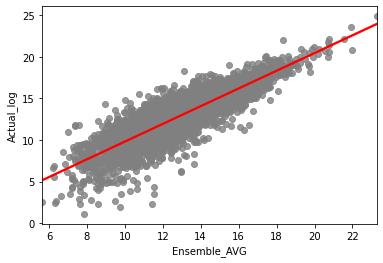

In [27]:
sns.regplot(x='Ensemble_AVG', y='Actual_log', line_kws={'color': 'red'}, scatter_kws={'color': 'grey'}, data=rslt_data)

<AxesSubplot:xlabel='Predict_value', ylabel='Actual_value'>

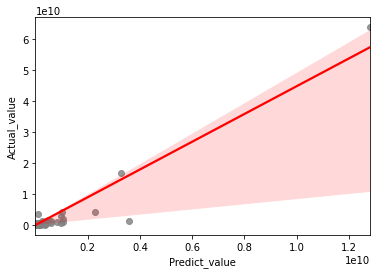

In [28]:
sns.regplot(x='Predict_value', y='Actual_value', line_kws={'color': 'red'}, scatter_kws={'color': 'grey'}, data=rslt_data)

### 3.2) 릿지 계수(Ridge Coeffiecents) 확인

In [29]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=model_data_onehot.drop('KR_TRADE_HSCD_COUNTRYCD',axis=1,inplace =False).columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10), nrows=1) #, ncols = 3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs.set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs.tick_params(axis="y",direction="in", pad=10)
        for label in (axs.get_xticklabels() + axs.get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs)

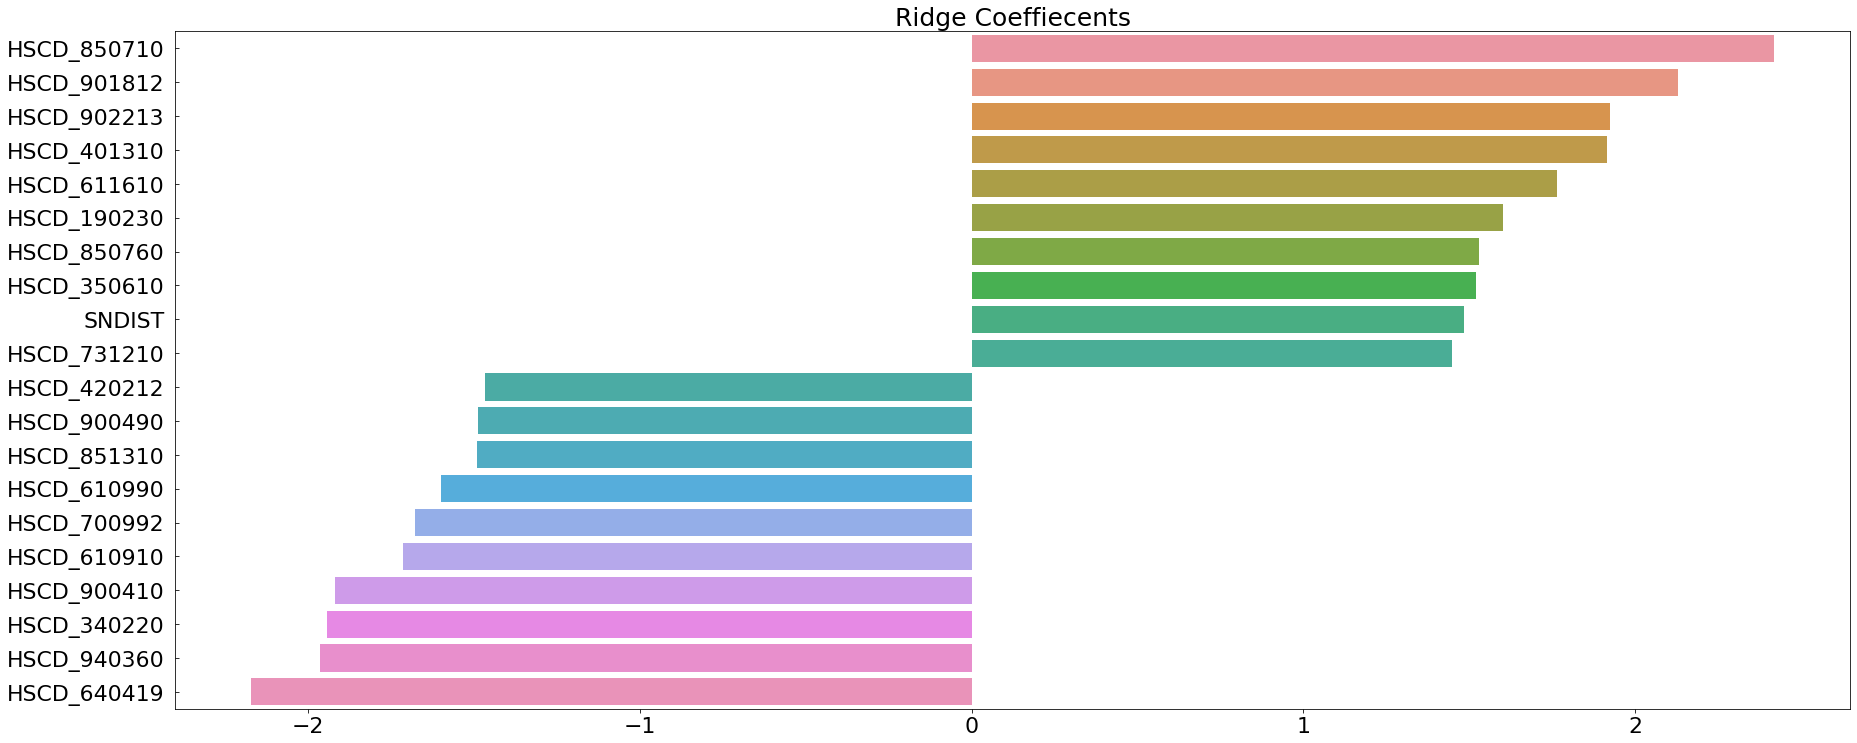

In [30]:
models = [Ridge_model]
visualize_coefficient(models)

### 3.3) 변수 중요도(Feature Importance) 확인

In [31]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=model_data_label.drop('KR_TRADE_HSCD_COUNTRYCD',axis=1,inplace =False).columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs.set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs.get_xticklabels() + axs.get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs)

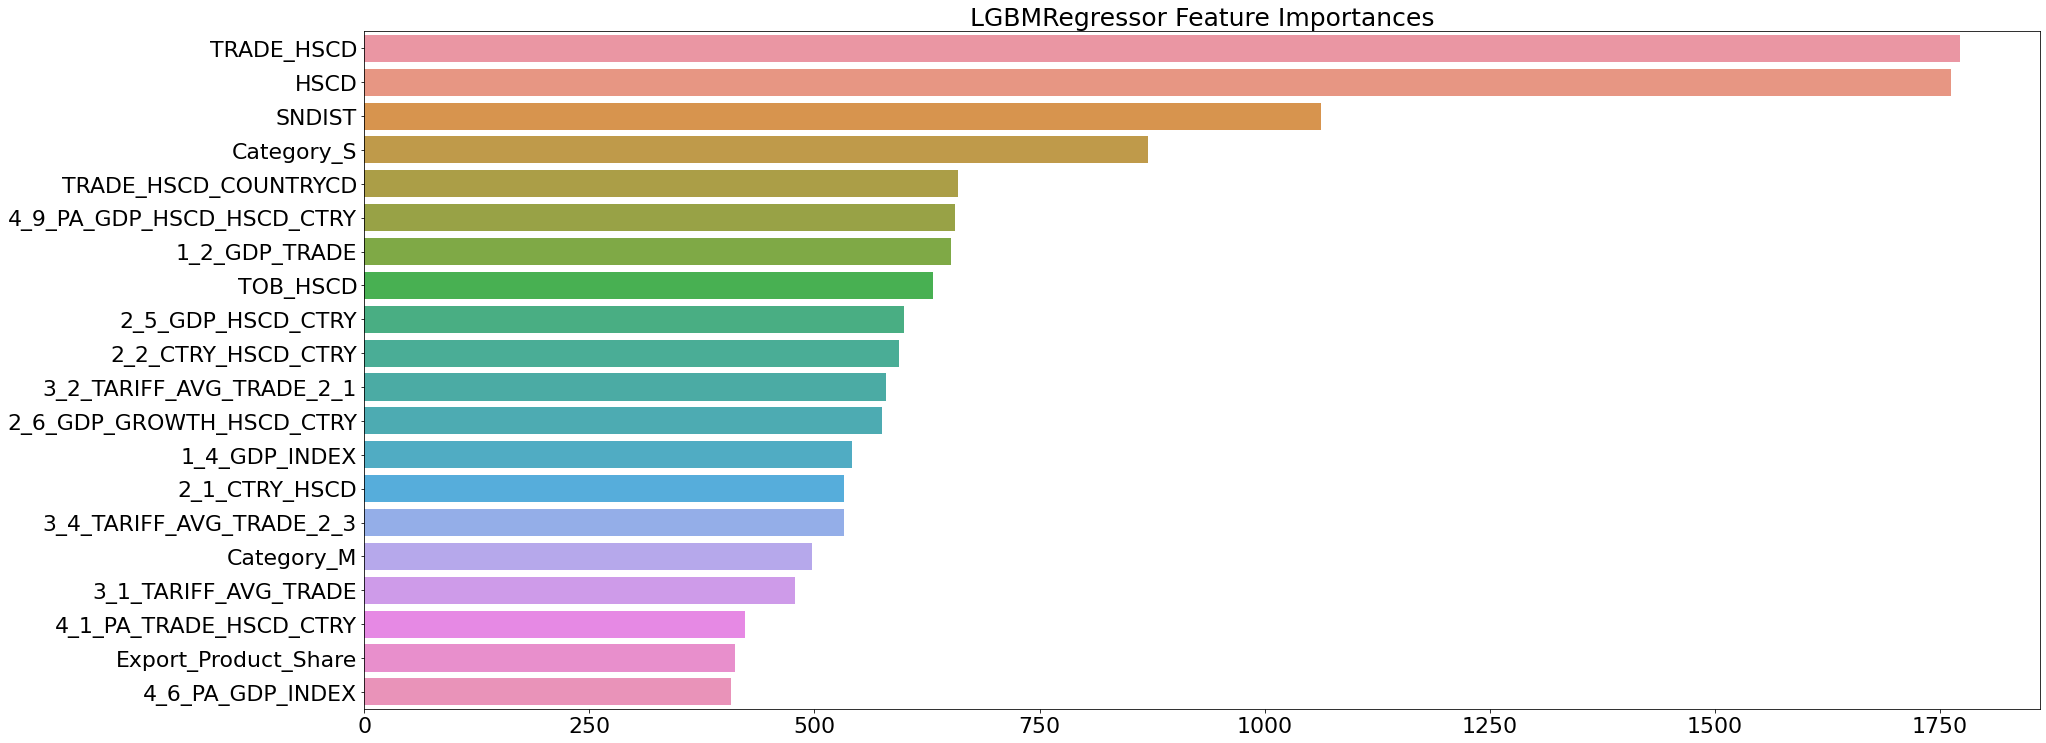

In [32]:
models = [model_lgb]
visualize_ftr_importances(models)

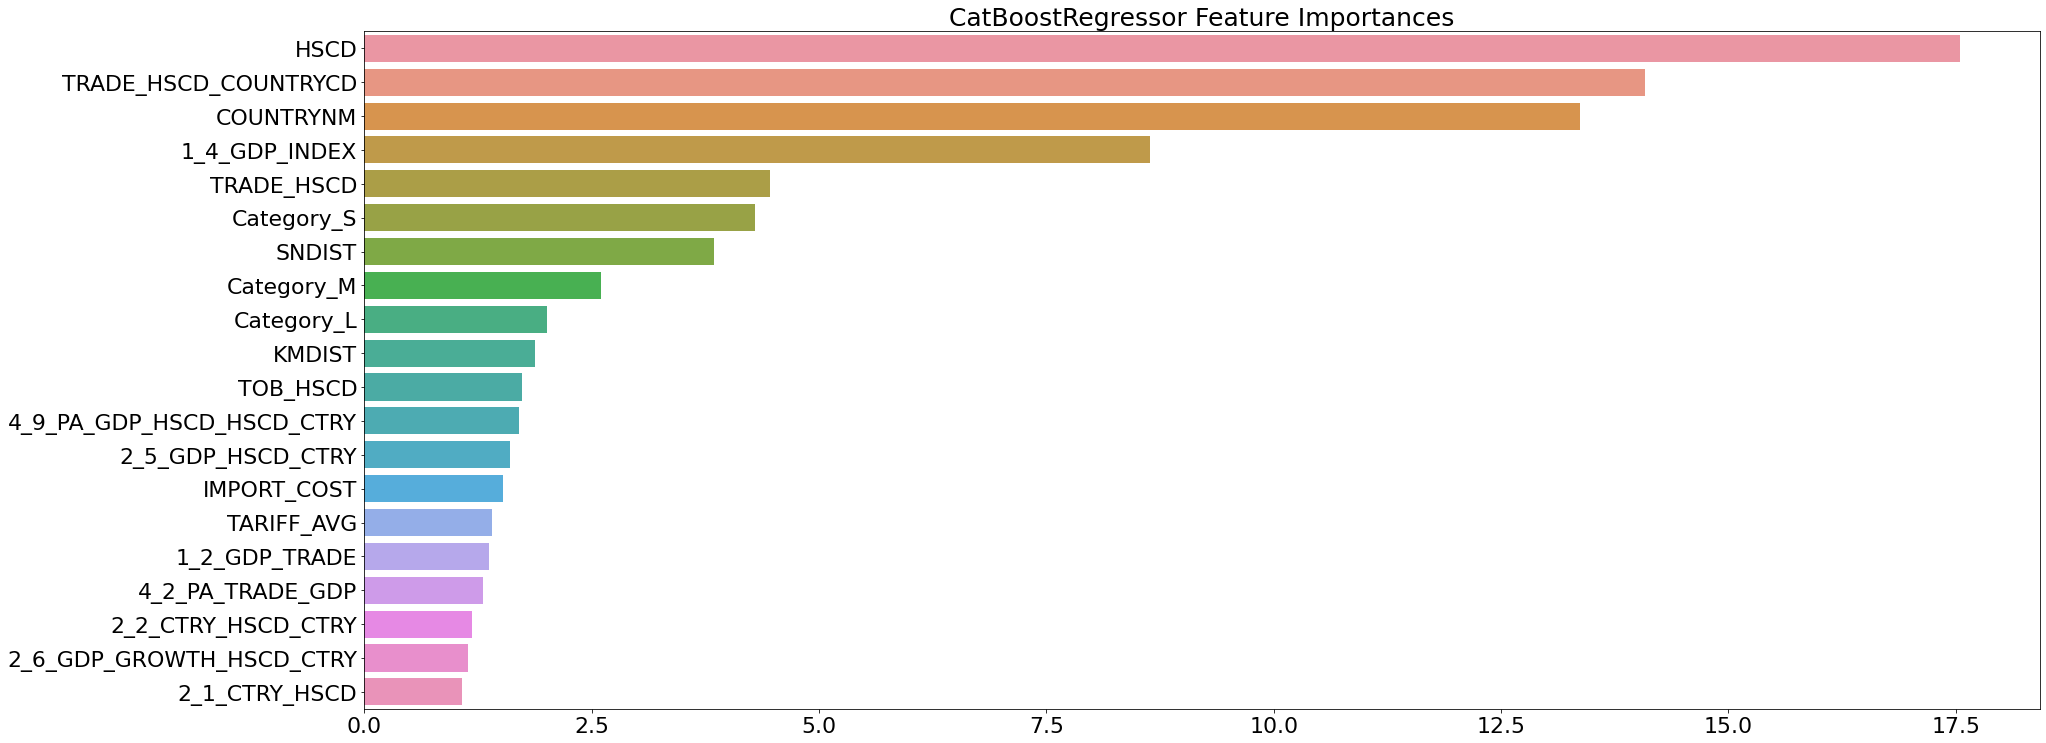

In [33]:
models = [model_cat]
visualize_ftr_importances(models)

### 3.4) 트리 맵(tree_map) 확인

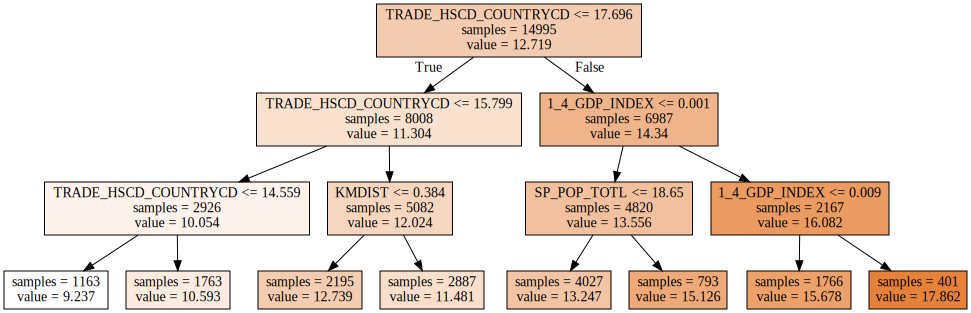

In [34]:
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

export_graphviz(tree, out_file='tree.dot',
                class_names='KR_TRADE_HSCD_COUNTRYCD',
                feature_names=model_data_label.drop('KR_TRADE_HSCD_COUNTRYCD',axis =1).columns,
                impurity=False,
                filled=True)

with open('tree.dot') as file_reader:
    dot_graph = file_reader.read()

dot = graphviz.Source(dot_graph) # dot_graph의 source 저장
dot.render(filename='tree.png') # png로 저장
dot

# 4. 활용 방안 : 수출유망품목 및 국가 추천

### 4.1) 군집화(Clustering) 전처리 - 2018년 예측 데이터

In [35]:
# 범주형 변수에 대해 object 형으로 변환
Cluster_data = predict_data_label.astype({'HSCD': 'str', 'COUNTRYNM' : 'str', 
                                       'Category_L' : 'str', 'Category_M' : 'str', 'Category_S' : 'str'})

# object형을 제외한 변수들에 대해 Minmax 정규화
numerical_feats = Cluster_data.dtypes[Cluster_data.dtypes != "object"].index.tolist()
Cluster_data[numerical_feats] = MinMaxScaler().fit_transform(Cluster_data[numerical_feats])

# 클러스터링을 위한 종속 변수 제거
Cluster_data.drop('KR_TRADE_HSCD_COUNTRYCD', axis = 1, inplace =True)
catColumnsPos = [Cluster_data.columns.get_loc(col) for col in list(Cluster_data.select_dtypes('object').columns)]

print('Categorical columns           : {}'.format(list(Cluster_data.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

dfMatrix = Cluster_data.to_numpy()

Categorical columns           : ['COUNTRYNM', 'HSCD', 'Category_L', 'Category_M', 'Category_S']
Categorical columns position  : [0, 1, 14, 15, 16]


### 4.2) 최적 K 탐색

In [36]:
# 최적 K 탐색 1 ~ 10 클러스터를 통해 비교
cost = []
for cluster in range(1, 11):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
        
# 클러스터 별 Cost를 데이터 프레임으로 변환        
df_cost = pd.DataFrame({'Cluster':range(1, 11), 'Cost':cost})
df_cost.head(10)

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10


,Cluster,Cost
0,1,28151.59707
1,2,23513.27817
2,3,22008.83999
3,4,20883.98313
4,5,19977.62726
5,6,19197.90488
6,7,18400.28172
7,8,17777.33642
8,9,17352.41895
9,10,16987.87190


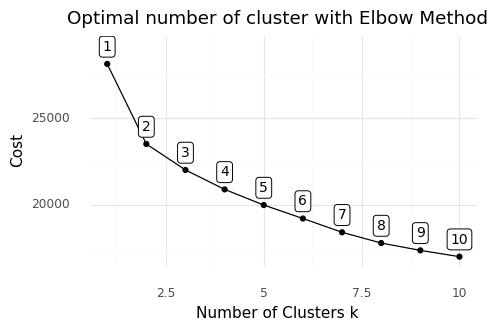

<ggplot: (172149712755)>

In [37]:
# 최적 K를 찾기 위한 Cost 감소 시각화
plotnine.options.figure_size = (5, 3)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

### 4.3) 최적 K를 통한 군집화(Clustering) 구성 및 시각화

In [38]:
# 클러스터링 학습
kprototype = KPrototypes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([3, 2, 2, ..., 3, 2, 2], dtype=uint16)

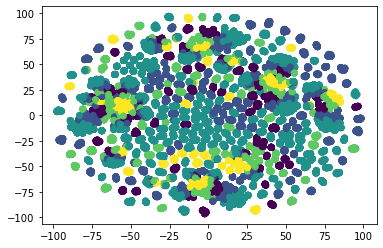

In [39]:
# 차원축소를 위해 원핫인코딩 데이터 사용, 정규화 진행
feature_df = predict_data_onehot.drop('KR_TRADE_HSCD_COUNTRYCD', axis =1, inplace = False)
feature_df = MinMaxScaler().fit_transform(feature_df)

# 2개의 차원으로 축소
transformed = TSNE(n_components=2).fit_transform(feature_df)

# 기존 데이터프레임에 레이블 추가
Cluster_data['cluster_id'] = kprototype.labels_

# 라벨은 클러스터별 색상으로 분류
plt.scatter(transformed[:,0], transformed[:,1], c=Cluster_data['cluster_id']) 
plt.show()

### 4.4) 군집화(Clustering)에 따른 해석

In [40]:
# 데이터 복사
Cluster_data_analysis = Cluster_data.copy()
Cluster_data_back = model_data.astype({'HSCD': 'str', 'COUNTRYNM' : 'str', 
                                       'Category_L' : 'str', 'Category_M' : 'str', 'Category_S' : 'str'})

# 이상치 제거
Cluster_data_back = model_data[model_data['KR_TRADE_HSCD_COUNTRYCD'] > 1]
Cluster_data_back = Cluster_data_back[Cluster_data_back['TRADE_HSCD_COUNTRYCD'] > 1]
Cluster_data_back.reset_index(drop=True, inplace=True)
Cluster_data_back.shape

# 데이터 변경(인코딩 원복)
Cluster_data_analysis['HSCD'] = Cluster_data_back['HSCD']
Cluster_data_analysis['COUNTRYNM'] = Cluster_data_back['COUNTRYNM']
Cluster_data_analysis['Category_L'] = Cluster_data_back['Category_L']
Cluster_data_analysis['Category_M'] = Cluster_data_back['Category_M']
Cluster_data_analysis['Category_S'] = Cluster_data_back['Category_S']

# 한국으로 부터 수입한 금액 변수 병합
Cluster_data_analysis['KR_TRADE_HSCD_COUNTRYCD'] = predict_rslt['Ensemble_AVG']

In [41]:
# 한국으로 부터 수입한 해당 국가별 특정 품목
def top(df, n=5, column='KR_TRADE_HSCD_COUNTRYCD'):
    return df.sort_values(by="KR_TRADE_HSCD_COUNTRYCD", ascending=False)[:n]

Cluster_data_analysis.groupby("cluster_id").apply(top, column="KR_TRADE_HSCD_COUNTRYCD", n=5)[['COUNTRYNM','IC_BUS_EASE_DFRN_DB',
      'TARIFF_AVG', 'KMDIST', '1_4_GDP_INDEX', 'Category_M', 'Category_S', 'KR_TRADE_HSCD_COUNTRYCD']]

COUNTRYNM  IC_BUS_EASE_DFRN_DB  TARIFF_AVG  \
cluster_id                                                                
0          445             Philippines              0.69141     0.02928   
           427                 Czechia              0.29120     0.18171   
           11466    Russian Federation              0.29120     0.22265   
           431    China, Hong Kong SAR              0.65784     0.23427   
           11005              Mongolia              0.65784     0.23427   
1          11471          South Africa              0.50469     0.26167   
           11512           Switzerland              0.50469     0.27085   
           11432          South Africa              0.50469     0.26167   
           13629                 Spain              0.50469     0.18171   
           12402                Canada              0.50469     0.26785   
2          11476                 Egypt              0.95519     0.00000   
           11436                Turkey              0.95519     0.00000   
           11453                 Italy              0.96708     0.00000   
           11517                   USA              0.95519     0.00000   
           11039  China, Hong Kong SAR              0.91669     0.35336   
3          451                Viet Nam              0.37135     0.00000   
           455    United Arab Emirates              0.40667     0.34928   
           11535            Kazakhstan              0.40667     0.00000   
           13652                 Italy              0.40667     0.00000   
           11493                 Japan              0.40667     0.00000   
4          11537              Malaysia              0.54498     0.14061   
           11495                Kuwait              0.54498     0.14061   
           11454                 Japan              0.54498     0.14061   
           13654            Kazakhstan              0.54498     0.17645   
           457                   Egypt              0.54498     0.31705   

                  KMDIST  1_4_GDP_INDEX Category_M Category_S  \
cluster_id                                                      
0          445   0.63781        0.12021        광산물      광물성연료   
           427   0.99939        0.08179        광산물      광물성연료   
           11466 0.99939        0.01982       IT부품        반도체   
           431   1.00000        0.02293        광산물      광물성연료   
           11005 1.00000        0.01272        기계류       전기기계   
1          11471 0.00000        0.96501       IT부품        반도체   
           11512 0.00000        1.00000        기계류       정밀기계   
           11432 0.00000        0.40565       IT부품        반도체   
           13629 0.00000        0.33264      내구소비재       가전제품   
           12402 0.00000        0.09711        기계류       전기기계   
2          11476 0.06545        0.07914       IT부품        반도체   
           11436 0.06545        0.09387       IT부품        반도체   
           11453 0.21361        0.04829       IT부품        반도체   
           11517 0.06545        0.08887        기계류       정밀기계   
           11039 0.58039        0.14049        기계류       전기기계   
3          451   0.09530        0.09432        광산물      광물성연료   
           455   0.21453        0.19883        광산물      광물성연료   
           11535 0.21453        0.16794        기계류       전기기계   
           13652 0.21453        0.41524      내구소비재       가전제품   
           11493 0.21453        0.06658        기계류       정밀기계   
4          11537 0.10244        0.40425        기계류       전기기계   
           11495 0.10244        0.14759        기계류       정밀기계   
           11454 0.10244        0.14755       IT부품        반도체   
           13654 0.10244        0.33951      내구소비재       가전제품   
           457   0.10244        0.18740        광산물      광물성연료   

                  KR_TRADE_HSCD_COUNTRYCD  
cluster_id                                 
0          445                   19.81751  
           427                   19.21242  
           11466                 18.73575  
           431             

- 다음 지표는 5개의 군집 별으로 이루어진 데이터로, 예측 모델에 사용한 다양한 파생변수를 기반으로 종합된 군집화 결과임.
- KR_TRADE_HSCD_COUNTRYCD을 기준으로 내림차순 한 결과로 군집 별 상위 5개씩 출력 하였음.
- 이는 각 군집별 다양한 정보를 종합적으로 비교 분석할 수 있으며, 세그멘트 별 추천을 통해 국가의 품목과 세부 카테고리를 확인할 수 있음.
- 이를 통하여 앙상블 예측 모델을 통해 다음 연도의 한국으로부터의 수출 금액을 예측하고 사용자는 사전적 행동을 개시할 수 있음.


### ▼ 해당 국가 및 품목에 따른 추천 예시 (서류에 자세히 서술)
- 1번 세그먼트의 경우 관세(TARIFF_AVG)를  보아, 수출하는 데 있어 어려움이 없을 것으로 보임.
- KMDIST의 변수를 통해 국내와 거리가 먼 것을 확인할 수 있음. 이에 대해 선적운반 시스템에 대한 고려가 필요해보임.
- 해당 품목의 1_4_GDP_INDEX 변수를 통해 해당 국가의 GDP 종합지수를 통해 자금확보 및 연체 여부를 확인할 수 있음.
- TRADE_HSCD_COUNTRYCD을 통해 해당 국가가 해당 품목에 대해 높은 수입액을 확인함.
- 이러한 다양한 변수와 요인을 고려하여 비교 분석을 통해 객관적이고 정량적으로 탐색과 추천을 할 수 있음.